### Install Requirements

In [2]:
# !pip install positional-encodings[pytorch]
# !pip install pyvis
# from google.colab import output
# output.enable_custom_widget_manager()

### Import Libraries

In [26]:
from positional_encodings.torch_encodings import *
import numpy as np
import random
import networkx as nx
from collections import defaultdict
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pyvis.network import Network
from IPython.display import display, HTML
import hashlib

from triangles_auxiliary_functions import generate_random_graphs, moving_average, show_graph_with_labels, get_unique_adj_matrices
from triangles_generation_functions import generate_dataset, generate_non_isomorphic_graphs, plot_graphs, generate_unique_random_graphs_with_triangles, generate_isomorphic_graphs
from statistics_helper_functions import calculate_graph_metrics, summarize_dataset_metrics, create_visualizations
from attention_analysis_functions import visualize_single_edge_attention, visualize_edge_attention, get_correct_example

### Traditional Positional Encoding

#### 2D

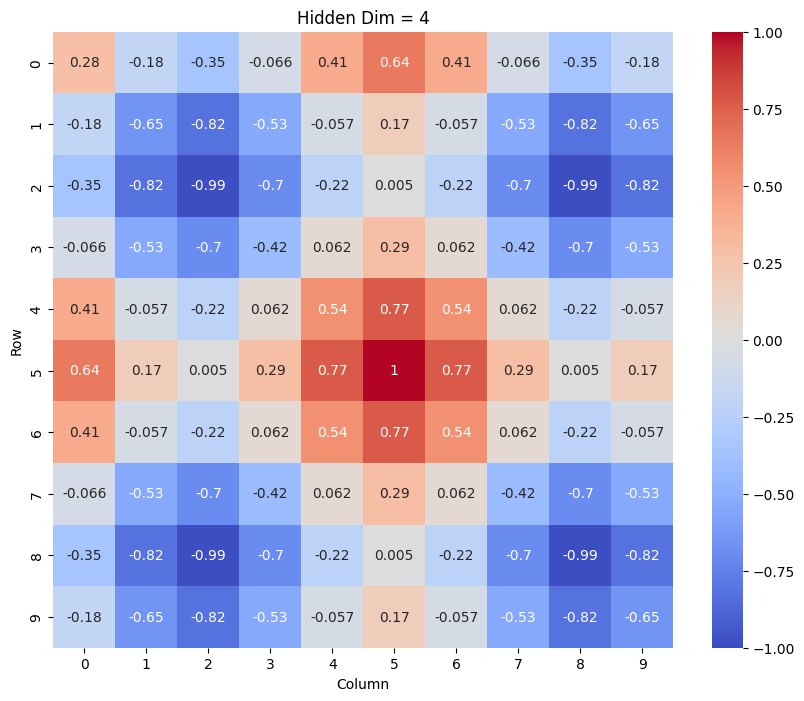

In [4]:
hidden_dim = 4
n_nodes = 10
p_enc_2d = Summer(PositionalEncoding2D(hidden_dim))
todos = p_enc_2d(torch.zeros([1, n_nodes, n_nodes, hidden_dim]))
mitad  = p_enc_2d(torch.zeros([1, n_nodes, n_nodes, hidden_dim]))[:, n_nodes//2, n_nodes//2, :]

# Create example tensors
tensor1 = todos
tensor2 = mitad

# Reshape tensor1 to (1, 25, 5) for easier computation
tensor1_reshaped = tensor1.view(1, n_nodes**2, hidden_dim)

# Compute cosine similarity
cosine_sim = F.cosine_similarity(tensor1_reshaped, tensor2.unsqueeze(1), dim=2)

# Reshape the result to (5, 5) for heatmap
cosine_sim_reshaped = cosine_sim.view(n_nodes, n_nodes)

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_reshaped.detach().numpy(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f'Hidden Dim = {hidden_dim}')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

#### 1D

torch.Size([1, 100, 32])


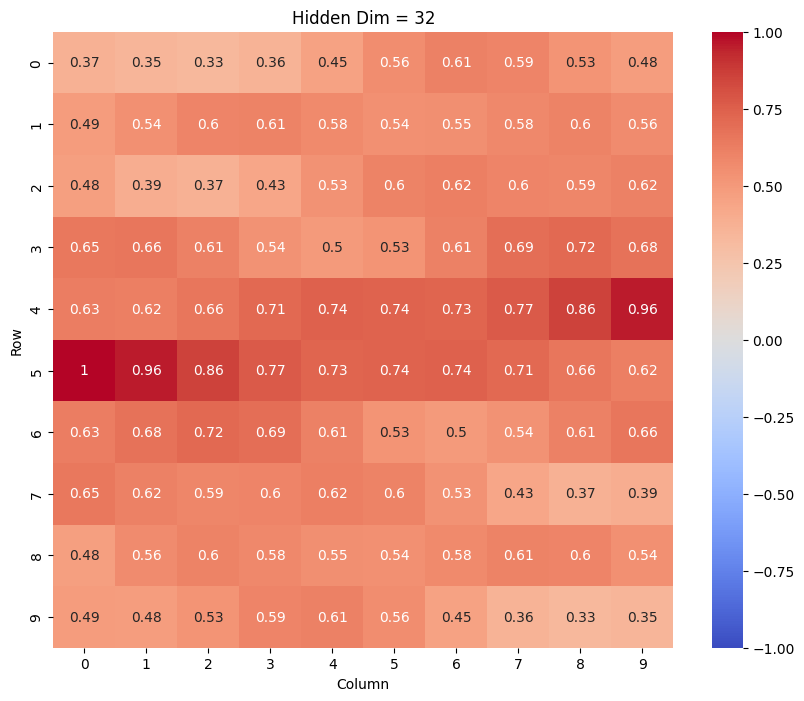

In [5]:
hidden_dim = 32
n_nodes = 10
p_enc_2d = Summer(PositionalEncoding1D(hidden_dim))
todos = p_enc_2d(torch.zeros([1, n_nodes*n_nodes, hidden_dim]))
print(todos.shape)
mitad  = todos[:, (n_nodes**2)//2, :]

# Create example tensors
tensor1 = todos
tensor2 = mitad

# Reshape tensor1 to (1, 25, 5) for easier computation
tensor1_reshaped = tensor1.view(1, n_nodes**2, hidden_dim)

# Compute cosine similarity
cosine_sim = F.cosine_similarity(tensor1_reshaped, tensor2.unsqueeze(1), dim=2)

# Reshape the result to (5, 5) for heatmap
cosine_sim_reshaped = cosine_sim.view(n_nodes, n_nodes)

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_reshaped.detach().numpy(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f'Hidden Dim = {hidden_dim}')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

### Vanilla Transformer

#### Transformer classes

In [11]:
class GraphTransformerClassifier(nn.Module):
    def __init__(self, max_nodes, hidden_dim, num_heads, num_layers, use_2d_encoding):
        super(GraphTransformerClassifier, self).__init__()
        self.max_nodes = max_nodes
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.use_2d_encoding = use_2d_encoding

        # Positional encoding
        if use_2d_encoding:
            self.pos_encoding = Summer(PositionalEncoding2D(hidden_dim))
        else:
            self.pos_encoding = Summer(PositionalEncoding1D(hidden_dim))

        # Initial transformation of adjacency matrix
        self.input_proj = nn.Linear(1, hidden_dim)

        # Graph Transformer layers
        self.layers = nn.ModuleList([
            GraphTransformerLayer(hidden_dim, num_heads)
            for _ in range(num_layers)
        ])

        # Binary classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, adj_matrix):
        # adj_matrix: [batch_size, num_nodes, num_nodes]
        batch_size, num_nodes, _ = adj_matrix.size()

        # Pad adjacency matrix if necessary
        if num_nodes < self.max_nodes:
            padding = torch.zeros(batch_size, self.max_nodes - num_nodes, num_nodes, device=adj_matrix.device)
            adj_matrix = torch.cat([adj_matrix, padding], dim=1)
            padding = torch.zeros(batch_size, self.max_nodes, self.max_nodes - num_nodes, device=adj_matrix.device)
            adj_matrix = torch.cat([adj_matrix, padding], dim=2)

        # Initial projection of adjacency matrix
        x = self.input_proj(adj_matrix.unsqueeze(-1))  # [batch_size, max_nodes, max_nodes, hidden_dim]

        if self.use_2d_encoding:
            # Add 2D positional encoding
            x = self.pos_encoding(x)
        else:
            # Reshape and add 1D positional encoding
            x = x.view(batch_size, self.max_nodes * self.max_nodes, self.hidden_dim)
            x = self.pos_encoding(x)

        # Reshape for transformer layers
        x = x.view(batch_size, self.max_nodes * self.max_nodes, self.hidden_dim)

        # Create attention mask
        attention_mask = adj_matrix.view(batch_size, self.max_nodes * self.max_nodes)
        attention_mask = attention_mask.unsqueeze(1).repeat(1, self.max_nodes * self.max_nodes, 1)
        attention_mask = (attention_mask == 0).float()
        attention_mask = attention_mask.repeat(self.num_heads, 1, 1)

        # Apply Graph Transformer layers
        attention_weights = []
        for layer in self.layers:
            x, attn_weights = layer(x, attention_mask)
            attention_weights.append(attn_weights)

        # Global mean pooling
        graph_embedding = x.mean(dim=1)

        # Binary classification
        output = self.classifier(graph_embedding)

        return output.squeeze(), attention_weights


In [12]:
class GraphTransformerLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super(GraphTransformerLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        # Multi-head attention
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )

        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)

    def forward(self, x, attention_mask):
        # x: node features [batch_size, max_nodes * max_nodes, hidden_dim]
        # attention_mask: [num_heads * batch_size, max_nodes * max_nodes, max_nodes * max_nodes]

        # Reshape for multi-head attention
        q = x.transpose(0, 1)
        k = x.transpose(0, 1)
        v = x.transpose(0, 1)

        # Compute attention scores
        attn_output, attn_weights = self.attention(q, k, v, attn_mask=attention_mask)
        attn_output = attn_output.transpose(0, 1)

        # Residual connection and layer norm
        x = x + attn_output
        x = self.layer_norm1(x)

        # Feed-forward network
        ff_output = self.ffn(x)

        # Residual connection and layer norm
        x = x + ff_output
        x = self.layer_norm2(x)

        return x, attn_weights

#### Using 2D Positional Encoding

In [8]:
# Example usage
max_nodes = 5
hidden_dim = 32
num_heads = 1
num_layers = 3
model = GraphTransformerClassifier(max_nodes, hidden_dim, num_heads, num_layers, True)

# Create a sample adjacency matrix (batch_size=1, num_nodes=5)
adj_matrix = torch.tensor([[[0, 1, 1, 0, 0],
                            [1, 0, 1, 0, 0],
                            [1, 1, 0, 0, 0],
                            [0, 0, 0, 0, 1],
                            [0, 0, 0, 1, 0]]], dtype=torch.float32)

output, attn_weights = model(adj_matrix)
print(f"Output: {output.item()}")

Output: 0.475900799036026


#### Using 1D Positional Encoding

In [9]:
# Example usage
max_nodes = 5
hidden_dim = 32
num_heads = 1
num_layers = 3
model = GraphTransformerClassifier(max_nodes, hidden_dim, num_heads, num_layers, False)

# Create a sample adjacency matrix (batch_size=1, num_nodes=5)
adj_matrix = torch.tensor([[[0, 1, 1, 0, 0],
                            [1, 0, 1, 0, 0],
                            [1, 1, 0, 0, 0],
                            [0, 0, 0, 0, 1],
                            [0, 0, 0, 1, 0]]], dtype=torch.float32)

output, attn_weights = model(adj_matrix)
print(f"Output: {output.item()}")

Output: 0.4766753315925598


#### Using Learnable Embedding Table

In [10]:
class GraphTransformerClassifierET(nn.Module):
    def __init__(self, max_nodes, hidden_dim, num_heads, num_layers):
        super(GraphTransformerClassifierET, self).__init__()
        self.max_nodes = max_nodes
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.num_layers = num_layers

        # Learnable embedding table
        self.embedding_table = nn.Embedding(max_nodes * max_nodes, hidden_dim)

        # Initial transformation of adjacency matrix
        self.input_proj = nn.Linear(1, hidden_dim)

        # Graph Transformer layers
        self.layers = nn.ModuleList([
            GraphTransformerLayer(hidden_dim, num_heads)
            for _ in range(num_layers)
        ])

        # Binary classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, adj_matrix):
        # adj_matrix: [batch_size, num_nodes, num_nodes]
        batch_size, num_nodes, _ = adj_matrix.size()

        # Pad adjacency matrix if necessary
        if num_nodes < self.max_nodes:
            padding = torch.zeros(batch_size, self.max_nodes - num_nodes, num_nodes, device=adj_matrix.device)
            adj_matrix = torch.cat([adj_matrix, padding], dim=1)
            padding = torch.zeros(batch_size, self.max_nodes, self.max_nodes - num_nodes, device=adj_matrix.device)
            adj_matrix = torch.cat([adj_matrix, padding], dim=2)

        # Initial projection of adjacency matrix
        x = self.input_proj(adj_matrix.unsqueeze(-1))  # [batch_size, max_nodes, max_nodes, hidden_dim]

        # Add learnable embeddings
        position_ids = torch.arange(self.max_nodes * self.max_nodes, device=x.device).unsqueeze(0).expand(batch_size, -1)
        position_embeddings = self.embedding_table(position_ids).view(batch_size, self.max_nodes, self.max_nodes, self.hidden_dim)
        x = x + position_embeddings

        # Reshape for transformer layers
        x = x.view(batch_size, self.max_nodes * self.max_nodes, self.hidden_dim)

        # Create attention mask
        attention_mask = adj_matrix.view(batch_size, self.max_nodes * self.max_nodes)
        attention_mask = attention_mask.unsqueeze(1).repeat(1, self.max_nodes * self.max_nodes, 1)
        attention_mask = (attention_mask == 0).float()
        attention_mask = attention_mask.repeat(self.num_heads, 1, 1)

        # Apply Graph Transformer layers
        attention_weights = []
        for layer in self.layers:
            x, attn_weights = layer(x, attention_mask)
            attention_weights.append(attn_weights)

        # Global mean pooling
        graph_embedding = x.mean(dim=1)

        # Binary classification
        output = self.classifier(graph_embedding)

        return output.squeeze(), attention_weights

# The GraphTransformerLayer class remains unchanged

# Example usage
max_nodes = 5
hidden_dim = 32
num_heads = 1
num_layers = 3
model = GraphTransformerClassifierET(max_nodes, hidden_dim, num_heads, num_layers)

# Create a sample adjacency matrix (batch_size=1, num_nodes=5)
adj_matrix = torch.tensor([[[0, 1, 1, 0, 0],
                            [1, 0, 1, 0, 0],
                            [1, 1, 0, 0, 0],
                            [0, 0, 0, 0, 1],
                            [0, 0, 0, 1, 0]]], dtype=torch.float32)

output, attn_weights = model(adj_matrix)
print(f"Output: {output.item()}")

Output: 0.5098404884338379


### Dataset 1 generation

In [11]:
num_nodes = 8
max_nodes = num_nodes
dataset_size_target = 200

graphs_with_triangle = generate_random_graphs(num_nodes=num_nodes, num_graphs=dataset_size_target//2, enforce_triangle=True)
graphs_without_triangle = generate_random_graphs(num_nodes=num_nodes, num_graphs=dataset_size_target//2, enforce_triangle=False)

adj_matrices = graphs_with_triangle + graphs_without_triangle

node_size_list= [5]
max_nodes = max(node_size_list)
dataset_size_target = 512

adj_matrices, labels = generate_dataset(dataset_size_target, node_size_list)
adj_matrices_1 = adj_matrices[list(map(bool,labels)), :, :]
adj_matrices_0 = adj_matrices[list(map(lambda x: bool(0**x),labels)), :, :]

Dataset Size: 374
With Triangle Size: 213
Without Triange Size: 161
Totals for each node size:
{5: {'with': 213, 'without': 161}}


### Visualization

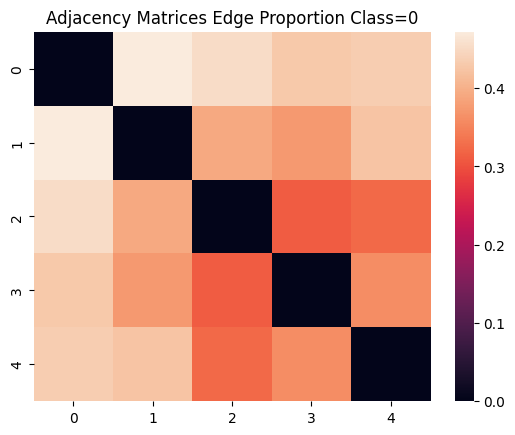

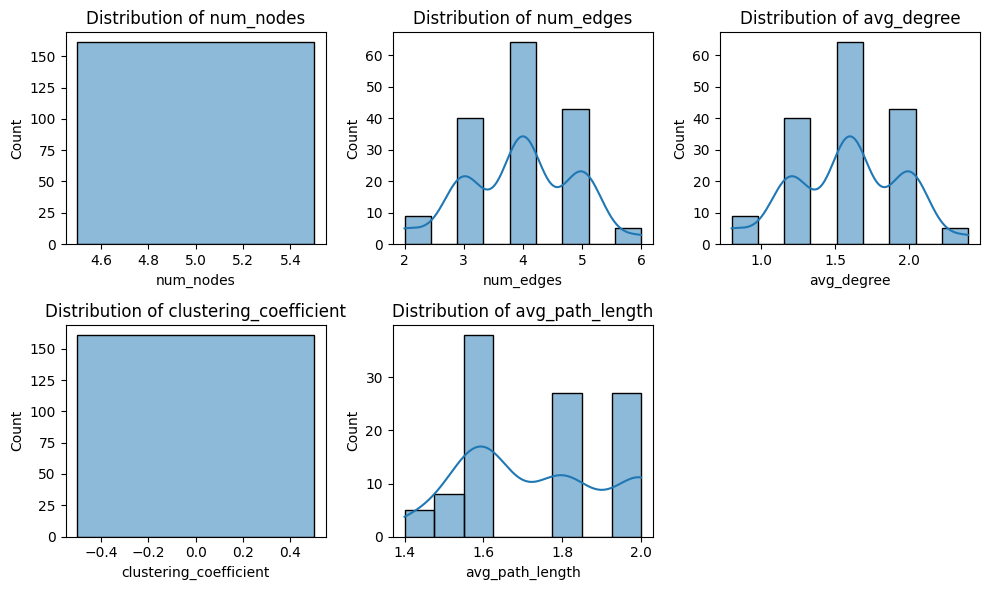

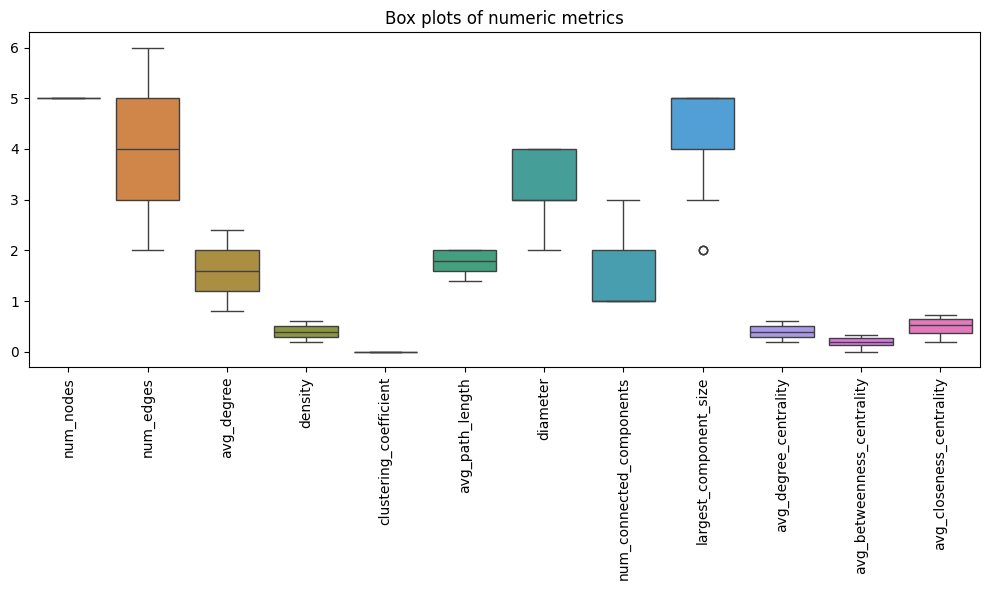

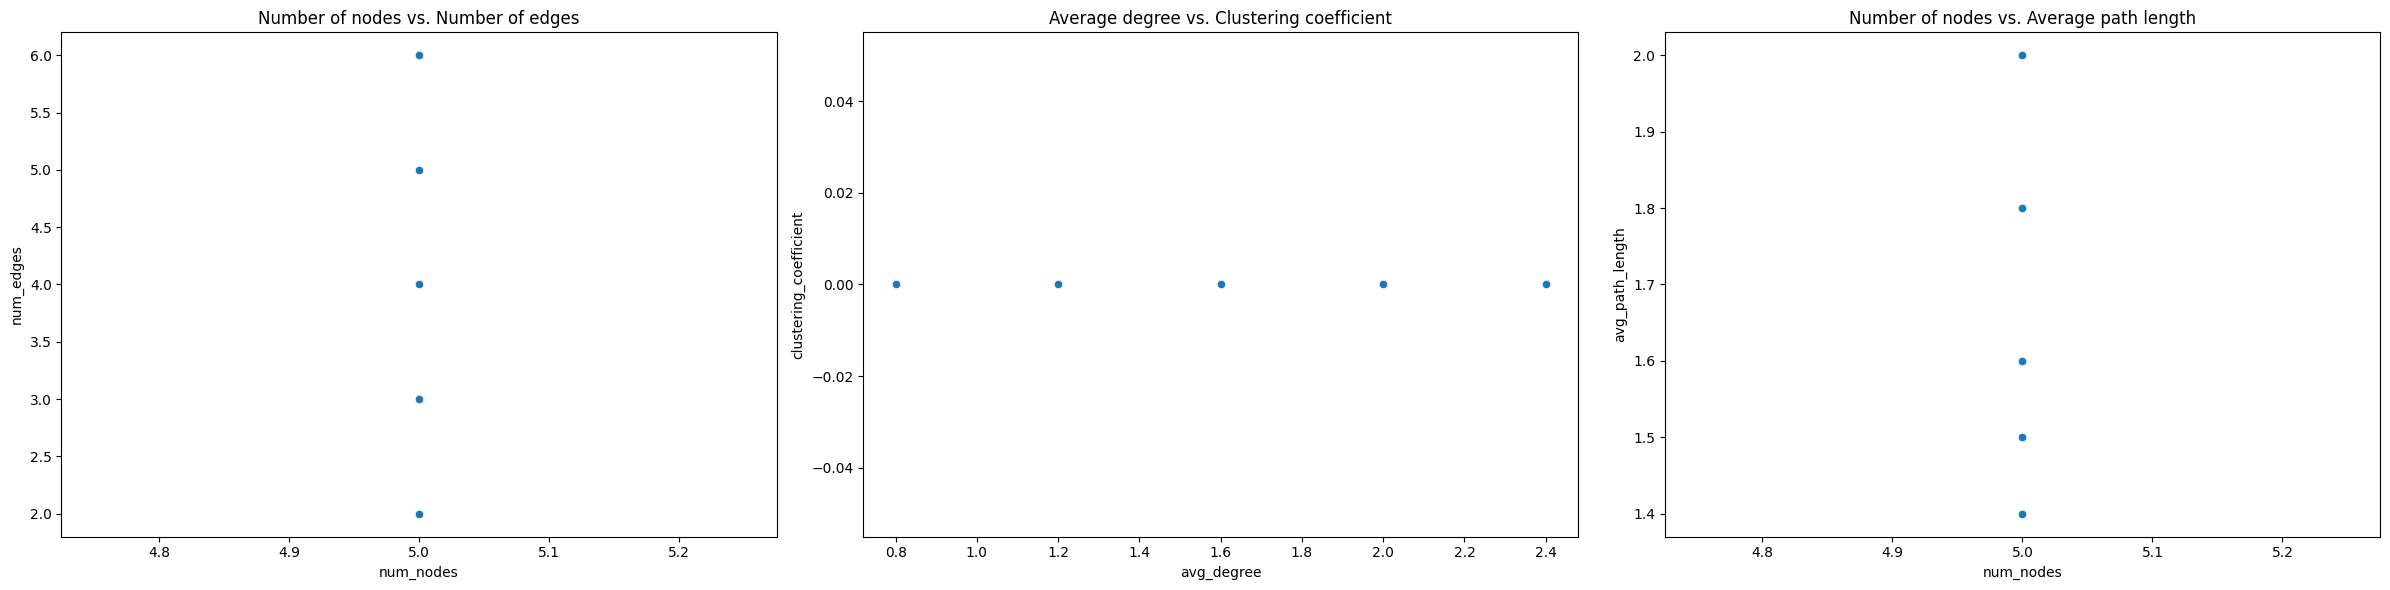

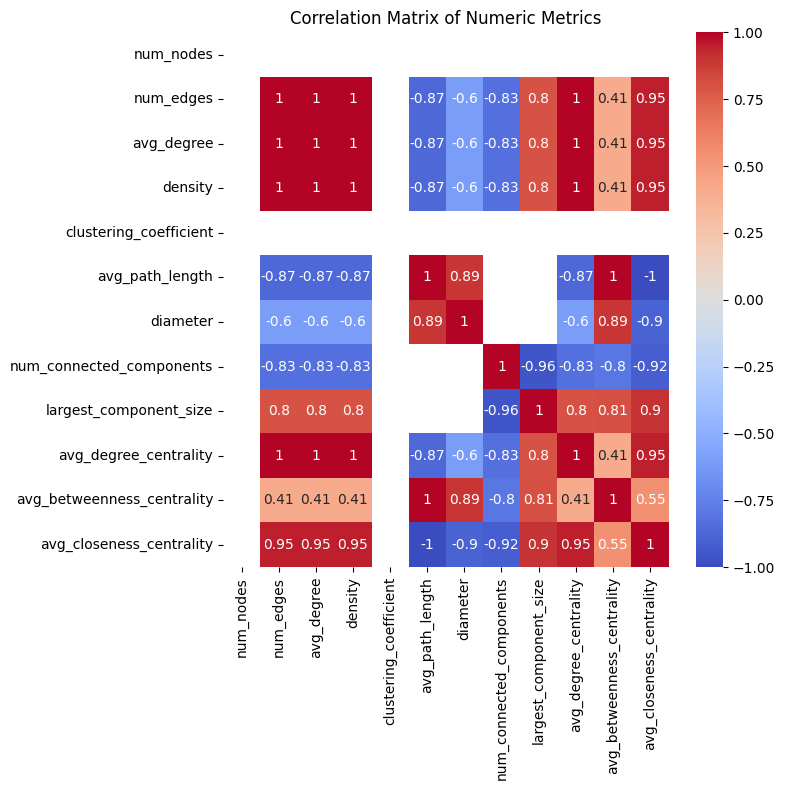

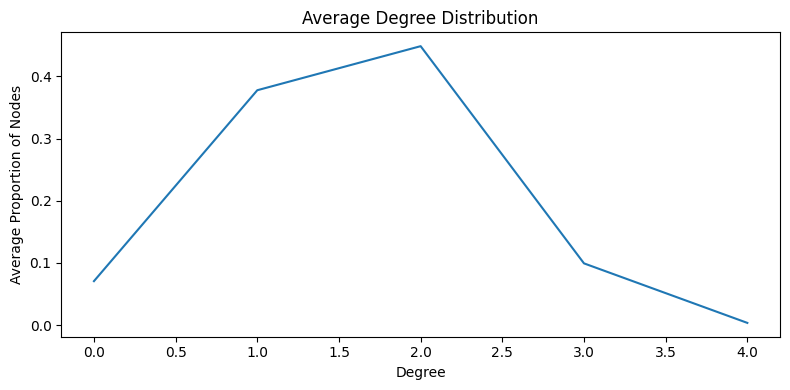

All visualizations have been displayed.


In [12]:
# Calculate metrics for each graph
individual_metrics = calculate_graph_metrics(adj_matrices_0)
# Calculate summary statistics for the dataset
dataset_summary = summarize_dataset_metrics(individual_metrics)
sns.heatmap(np.mean(adj_matrices_0, 0))
plt.title('Adjacency Matrices Edge Proportion Class=0')
# Create visualizations
create_visualizations(individual_metrics, dataset_summary)

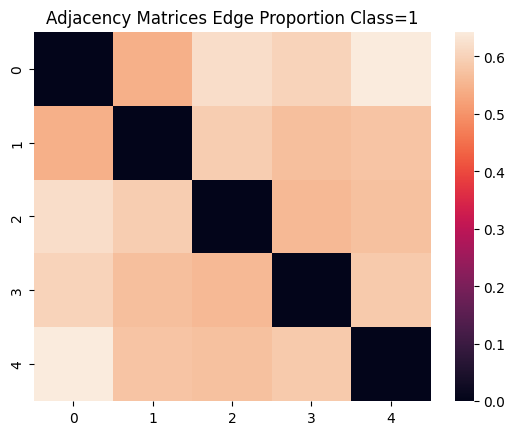

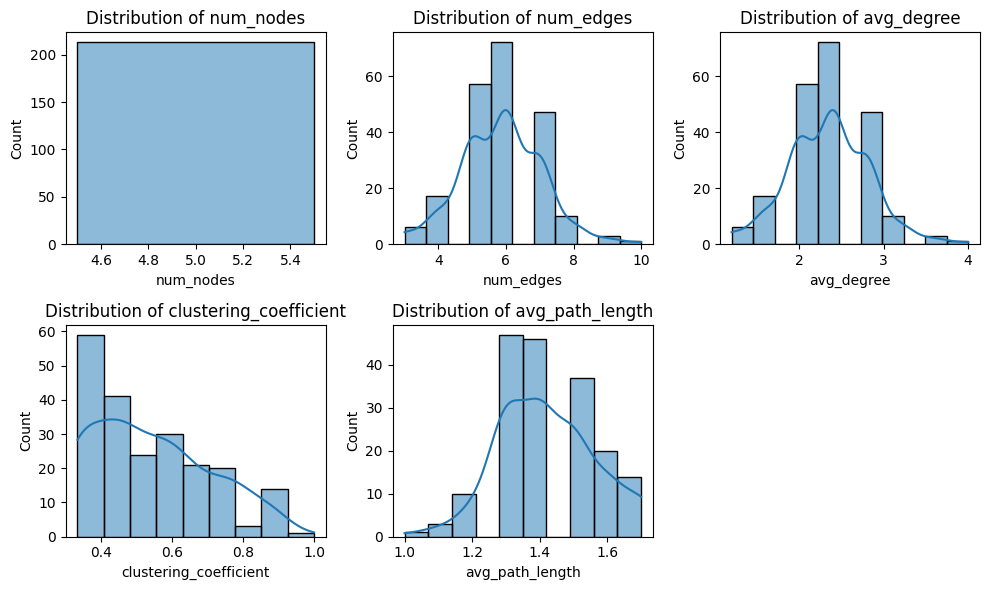

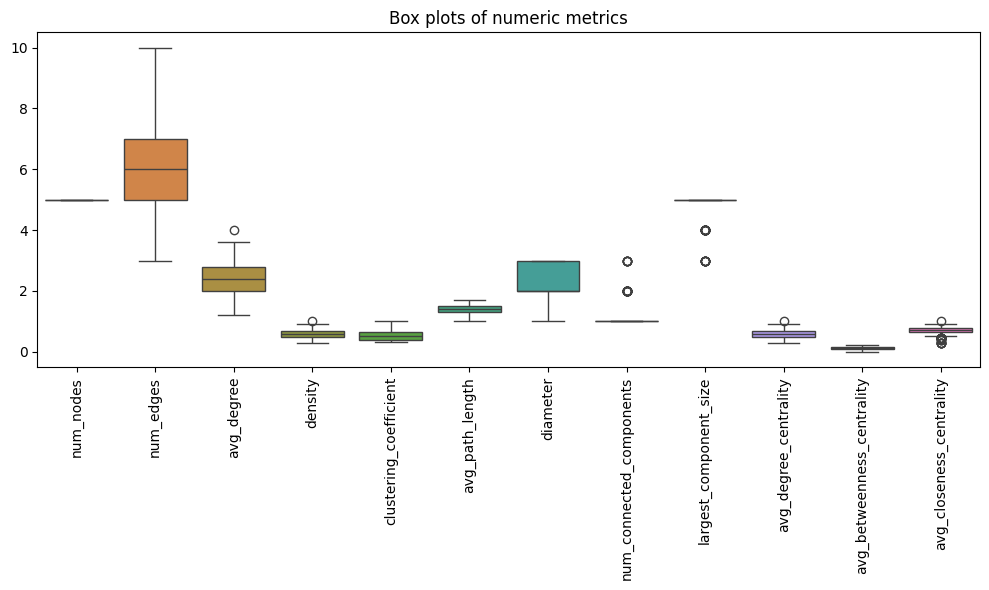

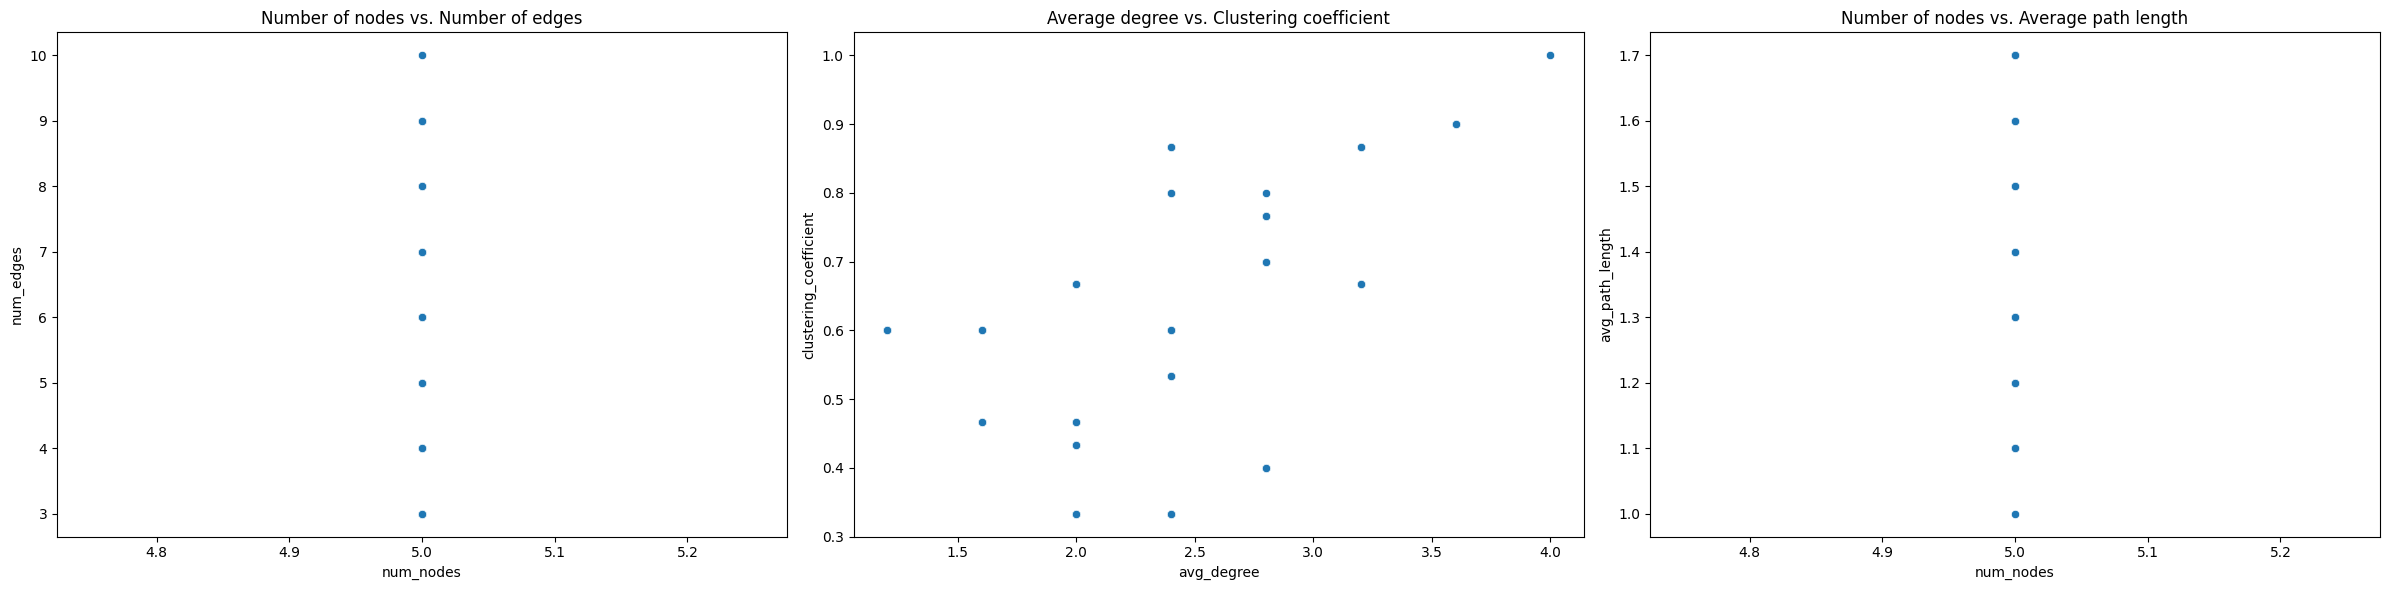

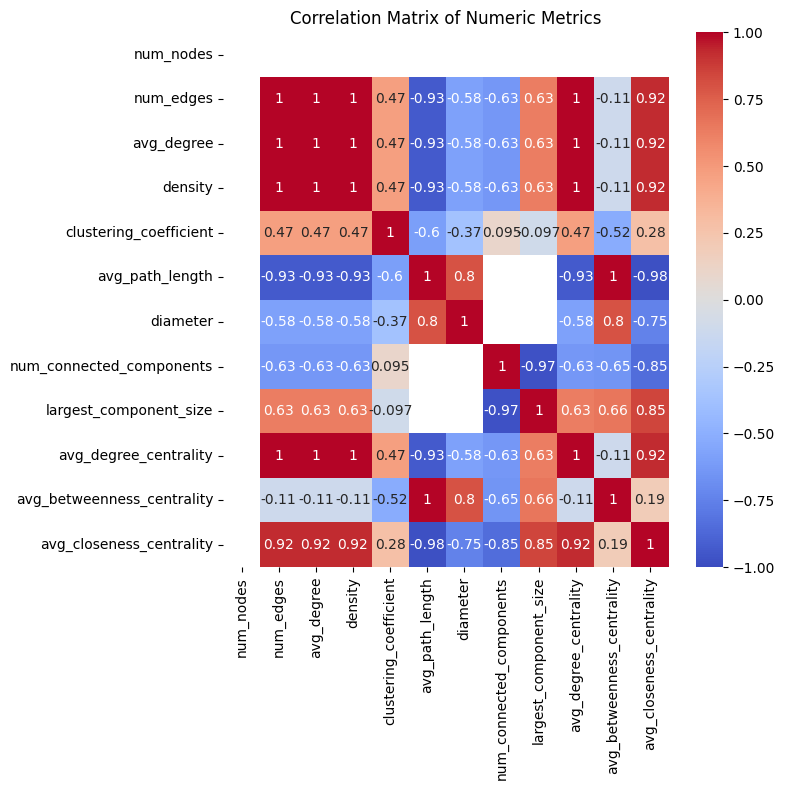

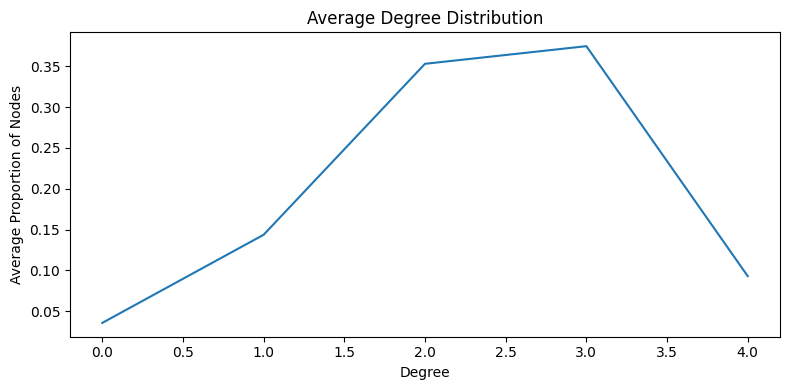

All visualizations have been displayed.


In [13]:
# Calculate metrics for each graph
individual_metrics = calculate_graph_metrics(adj_matrices_1)
# Calculate summary statistics for the dataset
dataset_summary = summarize_dataset_metrics(individual_metrics)
sns.heatmap(np.mean(adj_matrices_1, 0))
plt.title('Adjacency Matrices Edge Proportion Class=1')
# Create visualizations
create_visualizations(individual_metrics, dataset_summary)

### Training

In [14]:
class GraphDataset(Dataset):
    def __init__(self, adj_matrices, labels):
        self.adj_matrices = adj_matrices
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.adj_matrices[idx], self.labels[idx]

def collate_fn(batch):
    adj_matrices, labels = zip(*batch)

    # Find max number of nodes
    max_nodes = max(len(adj) for adj in adj_matrices)

    # Pad adjacency matrices
    padded_adj = []
    for adj in adj_matrices:
        pad_size = max_nodes - len(adj)
        padded = np.pad(adj, ((0, pad_size), (0, pad_size)), mode='constant')
        padded_adj.append(padded)

    # Convert to PyTorch tensors
    padded_adj = np.array(padded_adj)
    adj_tensor = torch.FloatTensor(padded_adj)

    labels_tensor = torch.FloatTensor(labels)

    return adj_tensor, labels_tensor

# adj_matrices: List of lists representing adjacency matrices
# labels: List of corresponding labels (0 or 1)

# Create dataset
dataset = GraphDataset(adj_matrices, labels)

# Create train-test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Initialize model, loss function, and optimizer
hidden_dim = 32
num_heads = 1
num_layers = 1
lr = 1e-3
num_epochs = 1000

# 2D positional encoding
model = GraphTransformerClassifier(max_nodes, hidden_dim, num_heads, num_layers, True)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=len(train_loader))


# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, labels in train_loader:
        adj, labels = adj.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for adj, labels in test_loader:
            adj, labels = adj.to(device), labels.to(device)
            outputs, attention_w = model(adj)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if (epoch+1)%10 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, '
            f'Val Loss: {val_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
    train_losses.append(round(train_loss/len(train_loader), 3))
    val_losses.append(round(val_loss/len(test_loader), 3))
    accuracies.append(round(100*correct/total, 3))

# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, labels in test_loader:
        adj, labels = adj.to(device), labels.to(device)
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

Epoch 10/1000, Train Loss: 0.6838, Val Loss: 0.6520, Accuracy: 52.00%
Epoch 20/1000, Train Loss: 0.6749, Val Loss: 0.6527, Accuracy: 52.00%
Epoch 30/1000, Train Loss: 0.6739, Val Loss: 0.6529, Accuracy: 52.00%
Epoch 40/1000, Train Loss: 0.6731, Val Loss: 0.6519, Accuracy: 52.00%
Epoch 50/1000, Train Loss: 0.6694, Val Loss: 0.6472, Accuracy: 52.00%
Epoch 60/1000, Train Loss: 0.6569, Val Loss: 0.6337, Accuracy: 52.00%
Epoch 70/1000, Train Loss: 0.6273, Val Loss: 0.5912, Accuracy: 52.00%
Epoch 80/1000, Train Loss: 0.5866, Val Loss: 0.5487, Accuracy: 52.00%
Epoch 90/1000, Train Loss: 0.4690, Val Loss: 0.4526, Accuracy: 81.33%
Epoch 100/1000, Train Loss: 0.4109, Val Loss: 0.4315, Accuracy: 74.67%
Epoch 110/1000, Train Loss: 0.3855, Val Loss: 0.4128, Accuracy: 76.00%
Epoch 120/1000, Train Loss: 0.3806, Val Loss: 0.4099, Accuracy: 76.00%
Epoch 130/1000, Train Loss: 0.3893, Val Loss: 0.3924, Accuracy: 77.33%
Epoch 140/1000, Train Loss: 0.3961, Val Loss: 0.3807, Accuracy: 80.00%
Epoch 150/1000,

In [15]:
# 1D positional encoding
model = GraphTransformerClassifier(max_nodes, hidden_dim, num_heads, num_layers, False)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=len(train_loader))


# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, labels in train_loader:
        adj, labels = adj.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for adj, labels in test_loader:
            adj, labels = adj.to(device), labels.to(device)
            outputs, attention_w = model(adj)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if (epoch+1)%10 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, '
            f'Val Loss: {val_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
    train_losses.append(round(train_loss/len(train_loader), 3))
    val_losses.append(round(val_loss/len(test_loader), 3))
    accuracies.append(round(100*correct/total, 3))

# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, labels in test_loader:
        adj, labels = adj.to(device), labels.to(device)
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

Epoch 10/1000, Train Loss: 0.6777, Val Loss: 0.6587, Accuracy: 52.00%
Epoch 20/1000, Train Loss: 0.6764, Val Loss: 0.6563, Accuracy: 52.00%
Epoch 30/1000, Train Loss: 0.6727, Val Loss: 0.6539, Accuracy: 52.00%
Epoch 40/1000, Train Loss: 0.6674, Val Loss: 0.6483, Accuracy: 52.00%
Epoch 50/1000, Train Loss: 0.6621, Val Loss: 0.6412, Accuracy: 52.00%
Epoch 60/1000, Train Loss: 0.6443, Val Loss: 0.6248, Accuracy: 52.00%
Epoch 70/1000, Train Loss: 0.6090, Val Loss: 0.5858, Accuracy: 60.00%
Epoch 80/1000, Train Loss: 0.5290, Val Loss: 0.5196, Accuracy: 82.67%
Epoch 90/1000, Train Loss: 0.4571, Val Loss: 0.4666, Accuracy: 77.33%
Epoch 100/1000, Train Loss: 0.4135, Val Loss: 0.4467, Accuracy: 78.67%
Epoch 110/1000, Train Loss: 0.3947, Val Loss: 0.3877, Accuracy: 81.33%
Epoch 120/1000, Train Loss: 0.3969, Val Loss: 0.3936, Accuracy: 77.33%
Epoch 130/1000, Train Loss: 0.3785, Val Loss: 0.3837, Accuracy: 80.00%
Epoch 140/1000, Train Loss: 0.3780, Val Loss: 0.3762, Accuracy: 81.33%
Epoch 150/1000,

In [16]:
# Embedding Table
model = GraphTransformerClassifierET(max_nodes, hidden_dim, num_heads, num_layers)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=len(train_loader))


# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, labels in train_loader:
        adj, labels = adj.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for adj, labels in test_loader:
            adj, labels = adj.to(device), labels.to(device)
            outputs, attention_w = model(adj)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if (epoch+1)%10 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, '
            f'Val Loss: {val_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
    train_losses.append(round(train_loss/len(train_loader), 3))
    val_losses.append(round(val_loss/len(test_loader), 3))
    accuracies.append(round(100*correct/total, 3))

# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, labels in test_loader:
        adj, labels = adj.to(device), labels.to(device)
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

Epoch 10/1000, Train Loss: 0.6826, Val Loss: 0.6728, Accuracy: 52.00%
Epoch 20/1000, Train Loss: 0.6790, Val Loss: 0.6653, Accuracy: 52.00%
Epoch 30/1000, Train Loss: 0.6724, Val Loss: 0.6594, Accuracy: 52.00%
Epoch 40/1000, Train Loss: 0.6705, Val Loss: 0.6542, Accuracy: 52.00%
Epoch 50/1000, Train Loss: 0.6670, Val Loss: 0.6485, Accuracy: 52.00%
Epoch 60/1000, Train Loss: 0.6575, Val Loss: 0.6413, Accuracy: 52.00%
Epoch 70/1000, Train Loss: 0.6398, Val Loss: 0.6236, Accuracy: 52.00%
Epoch 80/1000, Train Loss: 0.5883, Val Loss: 0.5703, Accuracy: 82.67%
Epoch 90/1000, Train Loss: 0.5014, Val Loss: 0.4948, Accuracy: 78.67%
Epoch 100/1000, Train Loss: 0.4318, Val Loss: 0.4490, Accuracy: 73.33%
Epoch 110/1000, Train Loss: 0.3849, Val Loss: 0.4012, Accuracy: 76.00%
Epoch 120/1000, Train Loss: 0.3629, Val Loss: 0.3869, Accuracy: 77.33%
Epoch 130/1000, Train Loss: 0.3450, Val Loss: 0.4132, Accuracy: 76.00%
Epoch 140/1000, Train Loss: 0.3101, Val Loss: 0.3973, Accuracy: 76.00%
Epoch 150/1000,

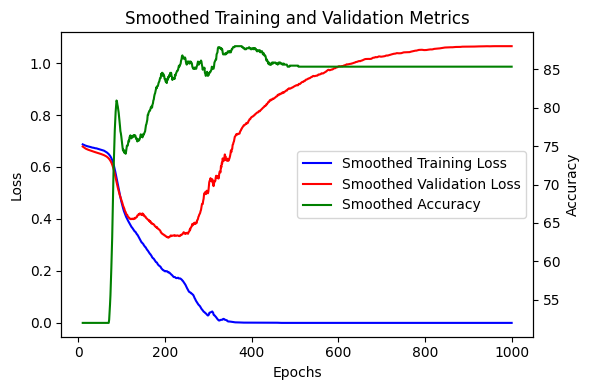

<Figure size 640x480 with 0 Axes>

In [17]:
# Define the window size for the moving average
window_size = 10  # Adjust this value to control the amount of smoothing

# Apply smoothing to the data
smooth_train_losses = moving_average(train_losses, window_size)
smooth_val_losses = moving_average(val_losses, window_size)
smooth_accuracies = moving_average(accuracies, window_size)

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(6, 4))

# Plot smoothed training and validation losses
epochs = range(window_size, len(train_losses) + 1)
ax1.plot(epochs, smooth_train_losses, 'b-', label='Smoothed Training Loss')
ax1.plot(epochs, smooth_val_losses, 'r-', label='Smoothed Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.tick_params(axis='y')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.plot(epochs, smooth_accuracies, 'g-', label='Smoothed Accuracy')
ax2.set_ylabel('Accuracy')
ax2.tick_params(axis='y')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

# Set title
plt.title('Smoothed Training and Validation Metrics')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Optionally, plot original data as faded lines for comparison
ax1.plot(range(1, len(train_losses) + 1), train_losses, 'b-', alpha=0.2)
ax1.plot(range(1, len(val_losses) + 1), val_losses, 'r-', alpha=0.2)
ax2.plot(range(1, len(accuracies) + 1), accuracies, 'g-', alpha=0.2)

plt.tight_layout()
plt.show()

### Attention Analysis

Correct example found:
Adjacency matrix shape: torch.Size([5, 5])
True label: 1.0
Model output: 1.0
Number of attention layers: 1
Layer 1 attention shape: torch.Size([64, 25, 25])


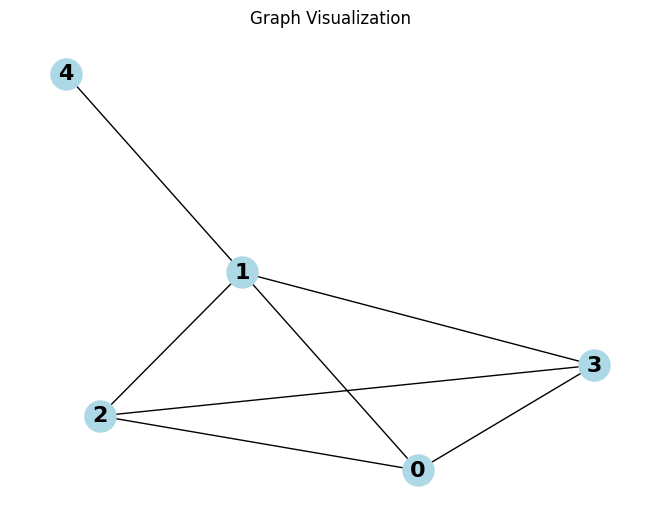

In [20]:
# Get a correct example with label 1
correct_adj, correct_label, correct_output, attention_weights = get_correct_example(model, test_loader, device, desired_label=1)

# Get a correct example with label 0
#correct_adj, correct_label, correct_output, attention_weights = get_correct_example(model, train_loader, device, desired_label=1)

if correct_adj is not None:
    print(f"Correct example found:")
    print(f"Adjacency matrix shape: {correct_adj.shape}")
    print(f"True label: {correct_label.item()}")
    print(f"Model output: {correct_output.item()}")
    print(f"Number of attention layers: {len(attention_weights)}")
    for i, layer_attention in enumerate(attention_weights):
        print(f"Layer {i+1} attention shape: {layer_attention.shape}")
else:
    print("No correctly classified examples found with the desired label in the test set.")

model.eval()
with torch.no_grad():
  correct_adj = correct_adj.to(device).unsqueeze(0)
  outputs, attention_weights = model(correct_adj)
show_graph_with_labels(correct_adj[0].detach().cpu().numpy())

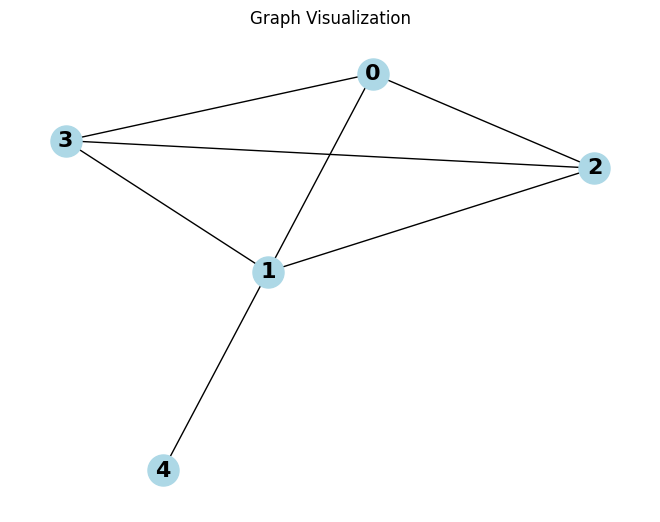

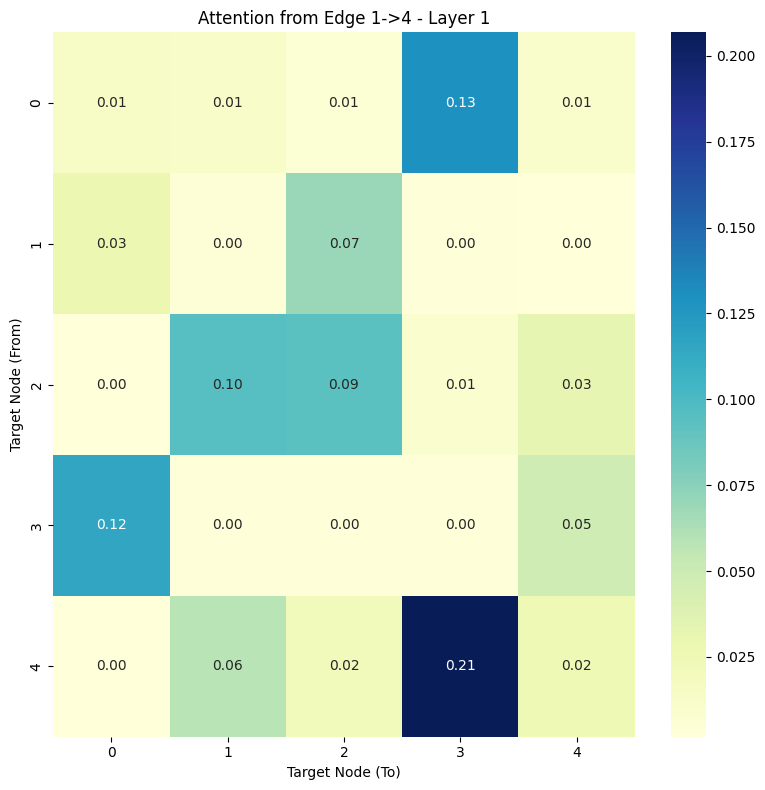

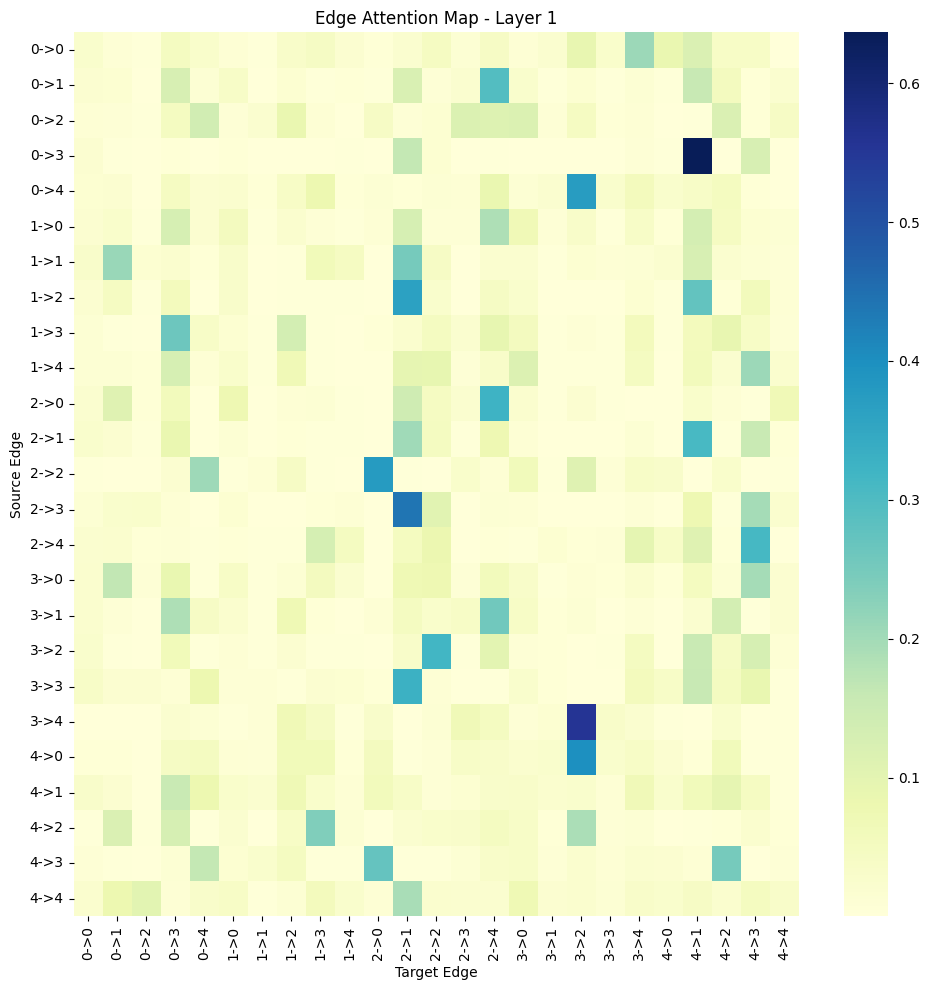

In [21]:
show_graph_with_labels(correct_adj[0].detach().cpu().numpy())
source_edge = (1,4)
visualize_single_edge_attention(attention_weights, layer_index=0, num_nodes=correct_adj[0].shape[0], source_edge=source_edge)

visualize_edge_attention(attention_weights, layer_index=0, num_nodes=correct_adj[0].shape[0], figsize=(10, 10))

### Dataset 2 -> After meeting of 25-07-24

1000
1000


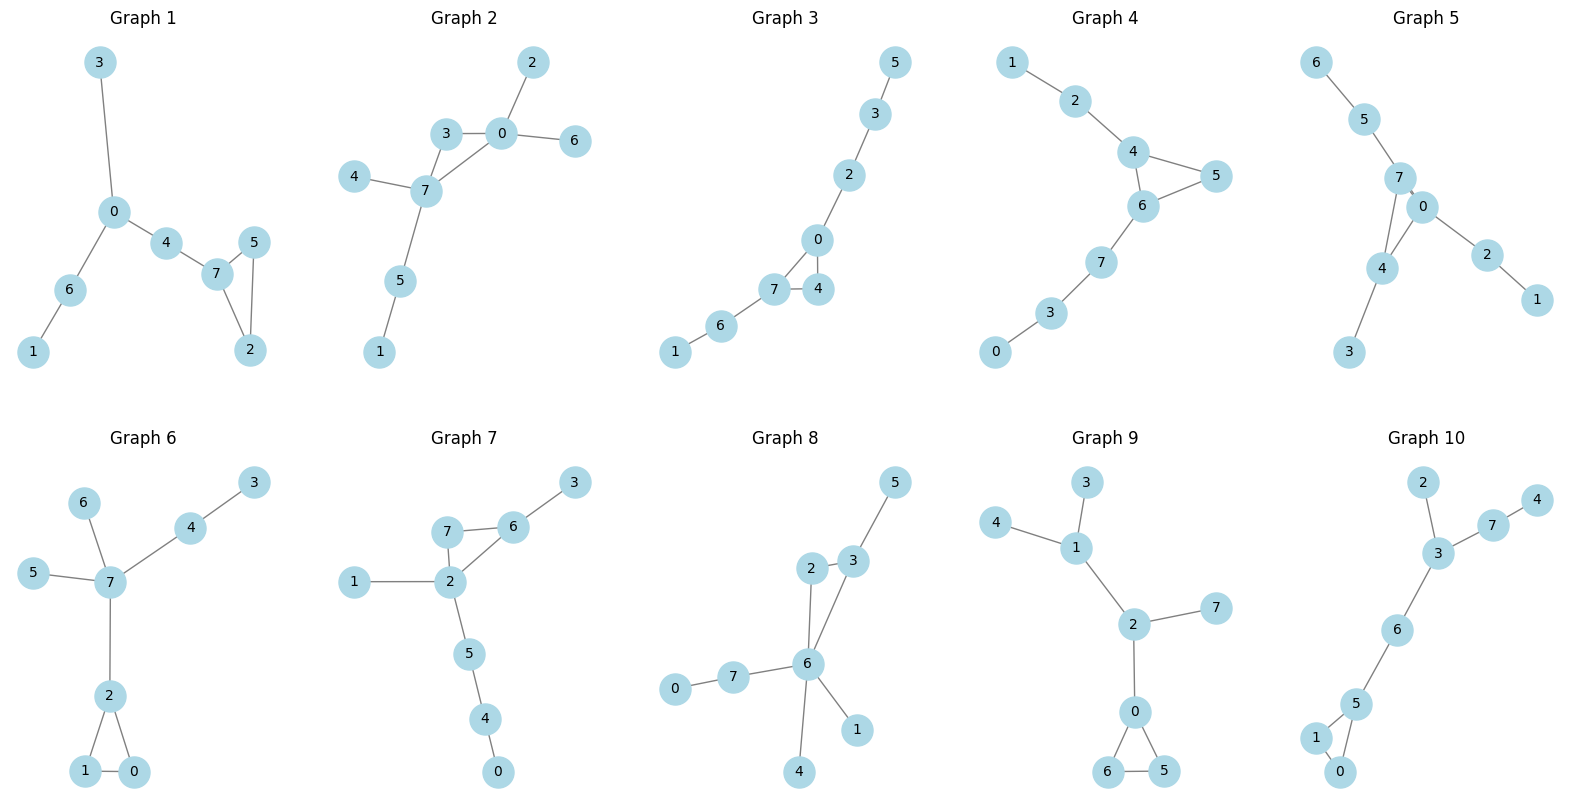

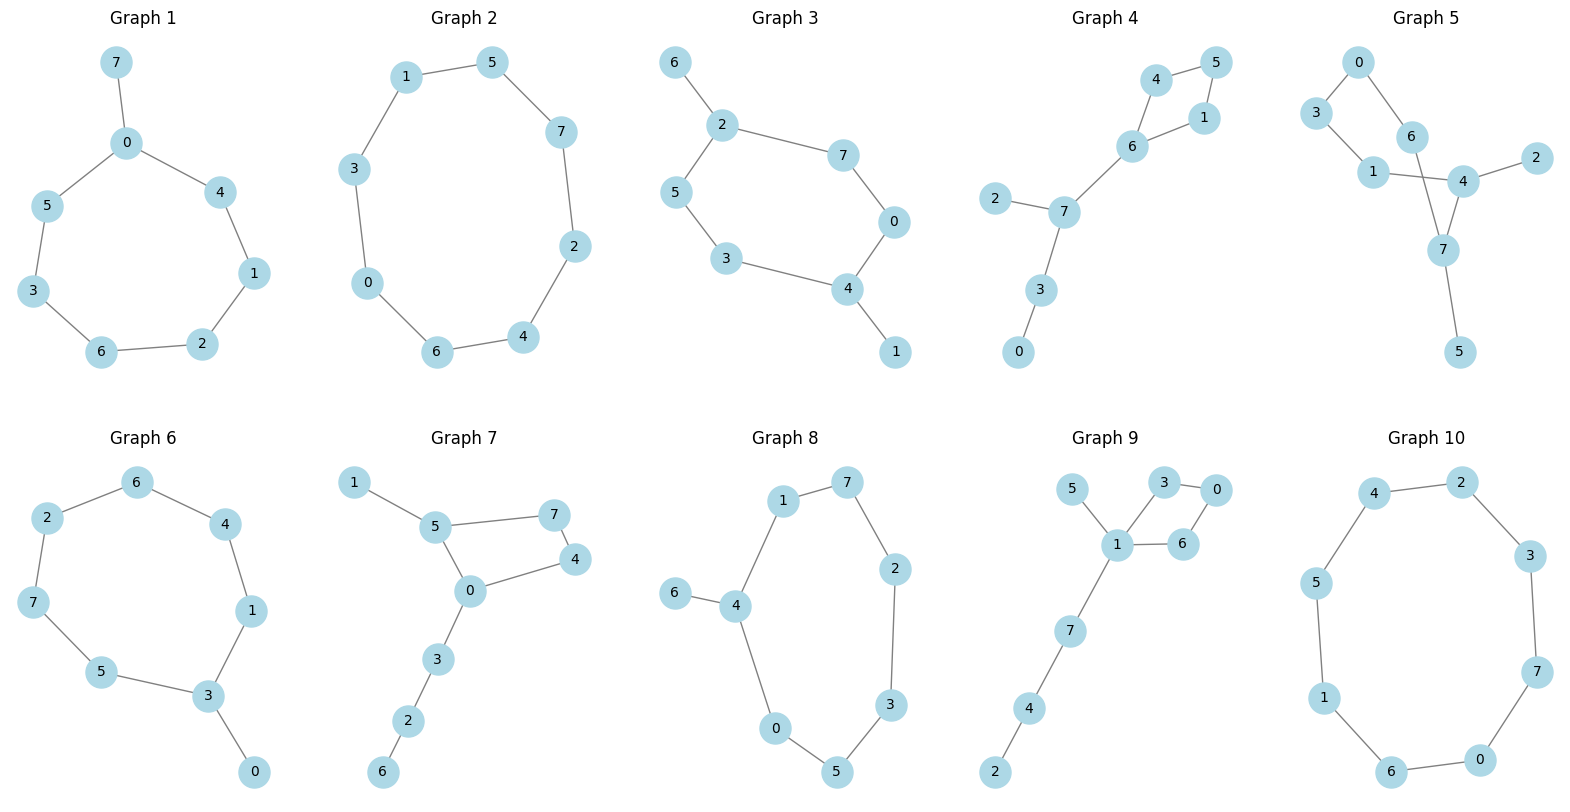

In [22]:
# Example usage
num_nodes = 8
allow_cycles = True
graphs_with_cycles, node_participation_with_cycles = generate_non_isomorphic_graphs(num_nodes, allow_cycles)
allow_cycles = False
graphs_without_cycles, node_participation_without_cycles = generate_non_isomorphic_graphs(num_nodes, allow_cycles)

for tree in graphs_without_cycles:
    nodes_with_degree_1 = {node: list(tree.neighbors(node)) for node in tree.nodes() if tree.degree(node) == 1}
    # print(nodes_with_degree_1)
    # pairs of nodes of degree 1 with different neighbors
    pairs = [(node1, node2) for node1, neighbors1 in nodes_with_degree_1.items() for node2, neighbors2 in nodes_with_degree_1.items() if node1 < node2 and neighbors1 != neighbors2]
    #print(pairs)
    # Select a random pair of nodes and add that edge to the tree
    if len(pairs) > 0:
        node1, node2 = random.choice(pairs)
        #print(f'Adding edge between {node1} and {node2}')
        tree.add_edge(node1, node2)

plot_graphs(graphs_with_cycles[:10], node_participation_with_cycles, num_nodes, True)  # Plot the first 10 non-isomorphic graphs with cycles
plot_graphs(graphs_without_cycles[:10], node_participation_without_cycles, num_nodes, False)  # Plot the first 10 non-isomorphic graphs without cycles

In [25]:
# Make adjacency matrix from the graphs with cycles and without cycles
adj_matrices_with_cycles = [nx.adjacency_matrix(g).todense() for g in graphs_with_cycles]
adj_matrices_without_cycles = [nx.adjacency_matrix(g).todense() for g in graphs_without_cycles]

# Combine the adjacency matrices into a single dataset
adj_matrices = np.array(adj_matrices_with_cycles + adj_matrices_without_cycles)
adj_matrices.shape

# Create a list with the values of the labels
labels = [1] * len(adj_matrices_with_cycles) + [0] * len(adj_matrices_without_cycles)
labels = np.array(labels)
labels

ceros = []
unos = []
for a, l in zip(adj_matrices, labels):
  if l == 1:
    unos.append(a)
  else:
    ceros.append(a)

print("Unique Adj:", len(get_unique_adj_matrices(adj_matrices)))

print("Size per class:")
print(len(unos), len(ceros))

print("Edges per class")
print(np.mean([np.sum(c) for c in unos]), np.mean([np.sum(c) for c in ceros]))

adj_matrices_1 = adj_matrices[list(map(bool,labels)), :, :]
adj_matrices_0 = adj_matrices[list(map(lambda x: bool(0**x),labels)), :, :]

Unique Adj: 1995
Size per class:
1000 1000
Edges per class
16.0 16.0


/var/folders/z7/4w4x_vfs7k79ky63zf8xhj2w0000gn/T/ipykernel_25954/1086754205.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrices_with_cycles = [nx.adjacency_matrix(g).todense() for g in graphs_with_cycles]
/var/folders/z7/4w4x_vfs7k79ky63zf8xhj2w0000gn/T/ipykernel_25954/1086754205.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrices_without_cycles = [nx.adjacency_matrix(g).todense() for g in graphs_without_cycles]


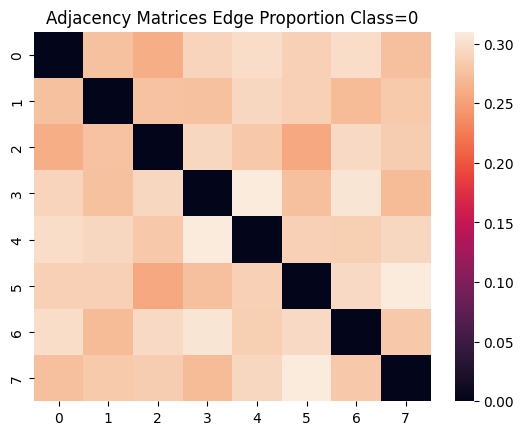

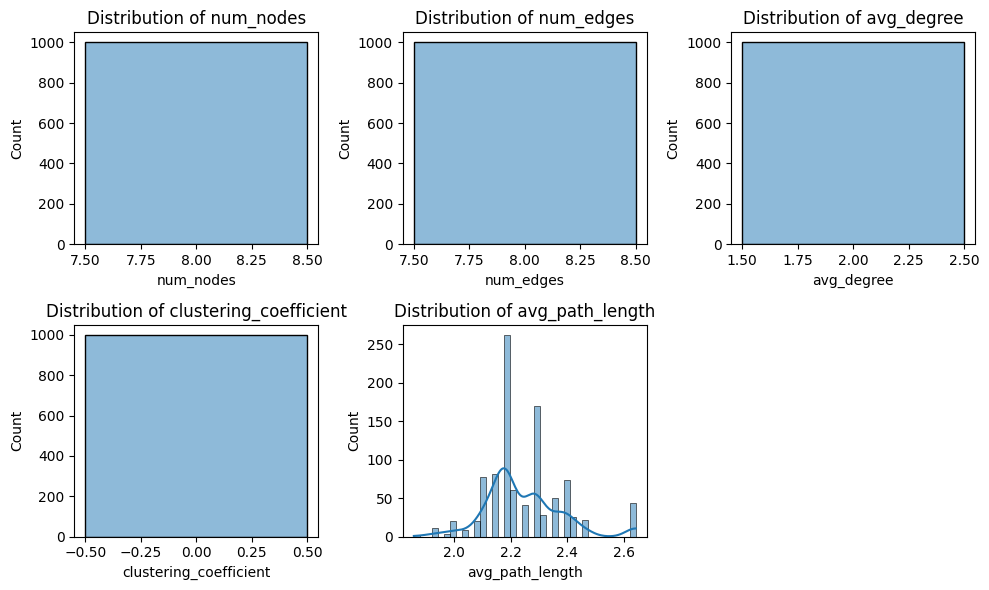

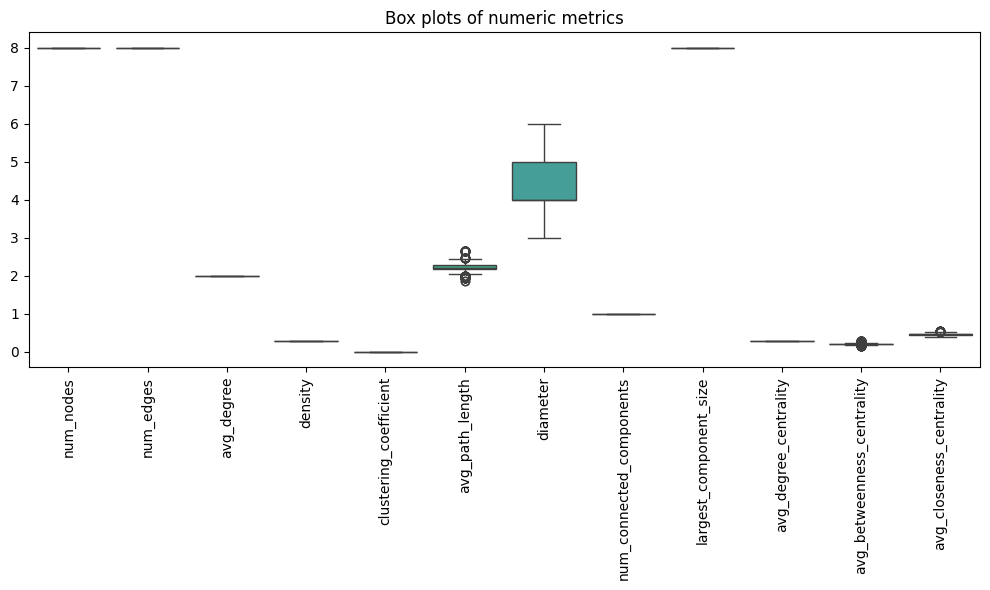

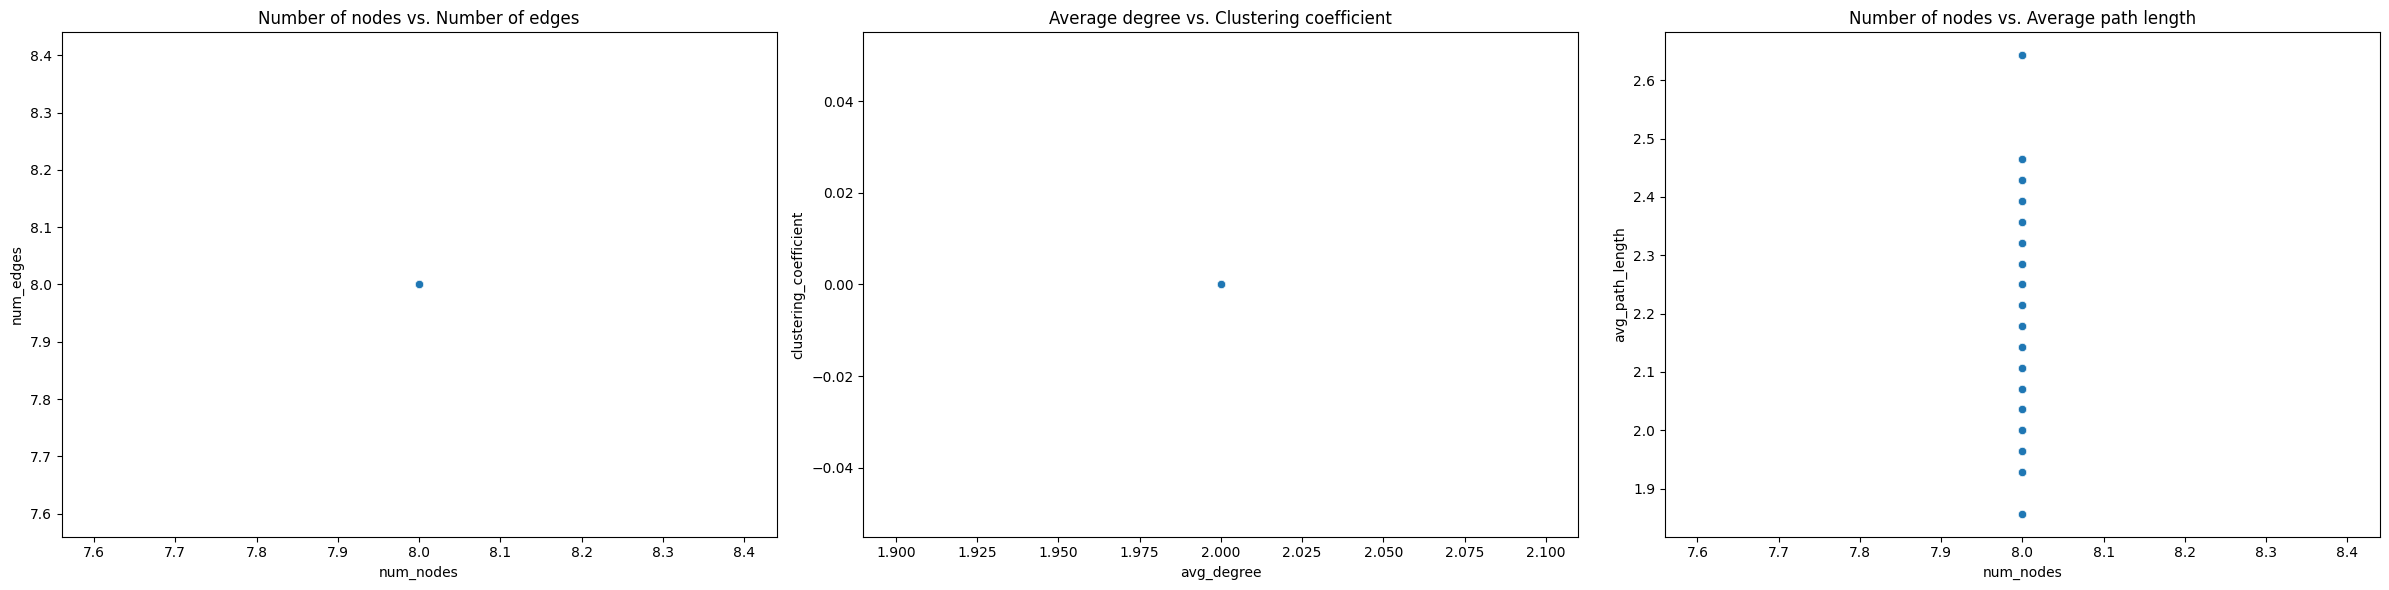

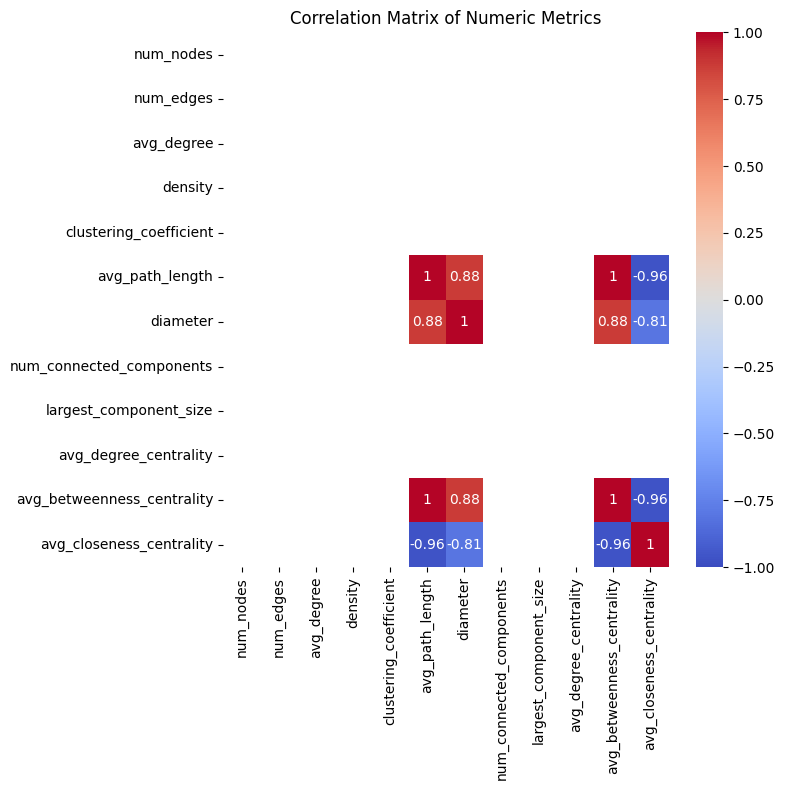

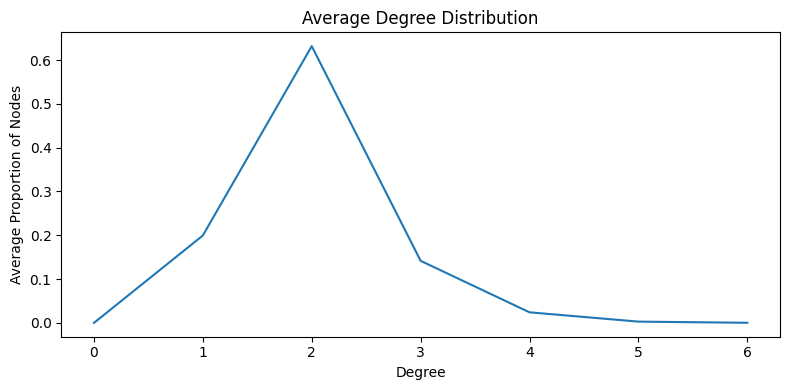

All visualizations have been displayed.


In [26]:
# Calculate metrics for each graph
individual_metrics = calculate_graph_metrics(adj_matrices_0)
# Calculate summary statistics for the dataset
dataset_summary = summarize_dataset_metrics(individual_metrics)
sns.heatmap(np.mean(adj_matrices_0, 0))
plt.title('Adjacency Matrices Edge Proportion Class=0')
# Create visualizations
create_visualizations(individual_metrics, dataset_summary)

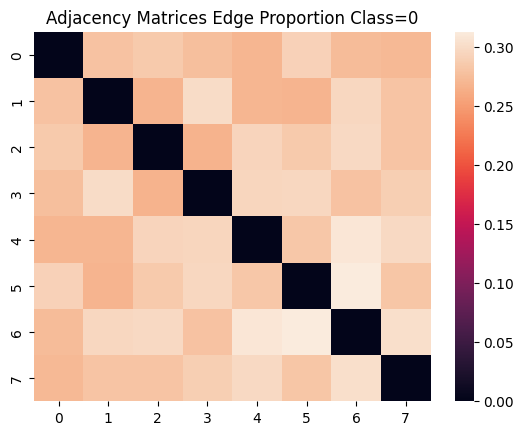

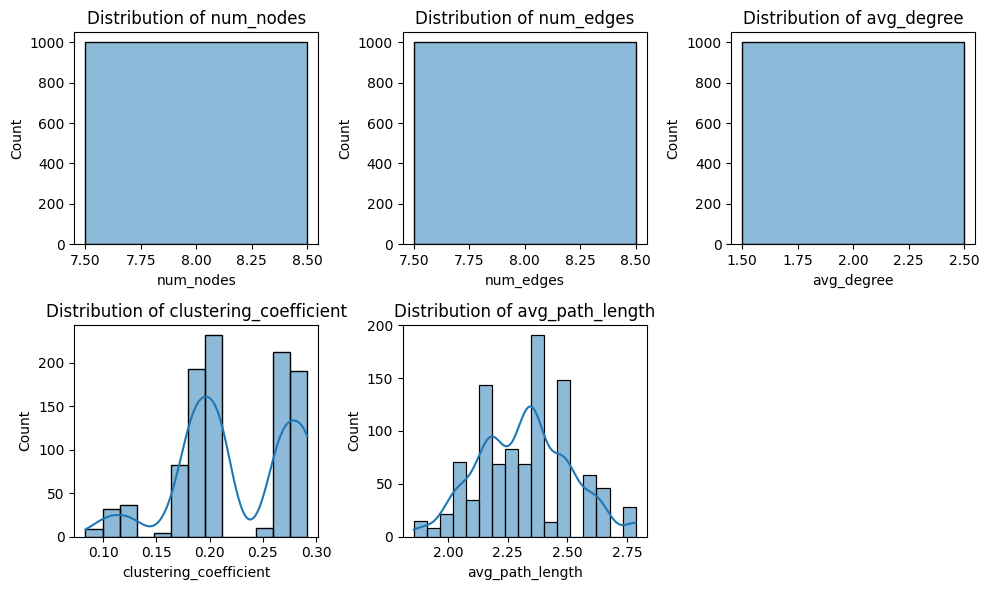

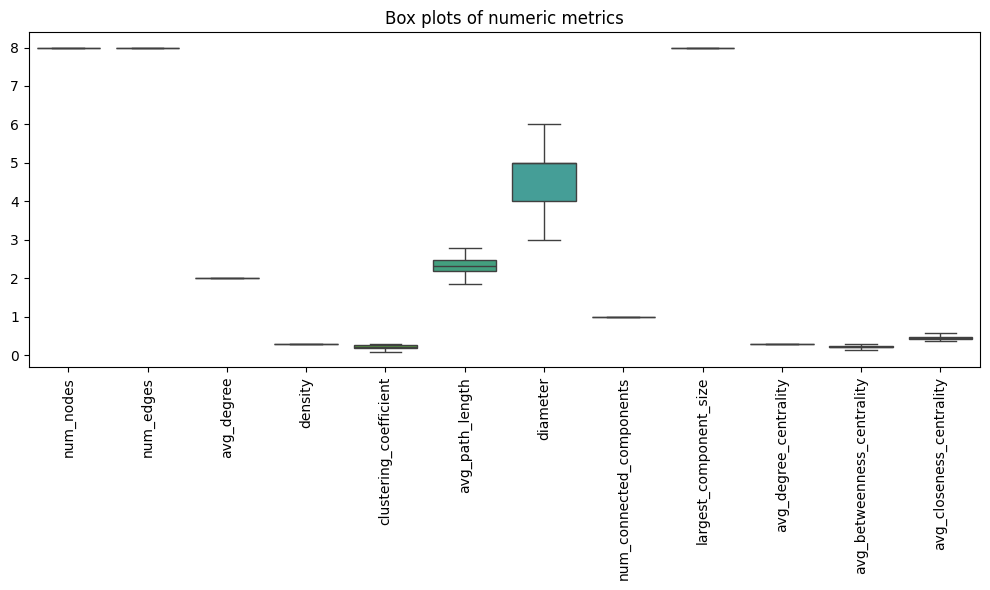

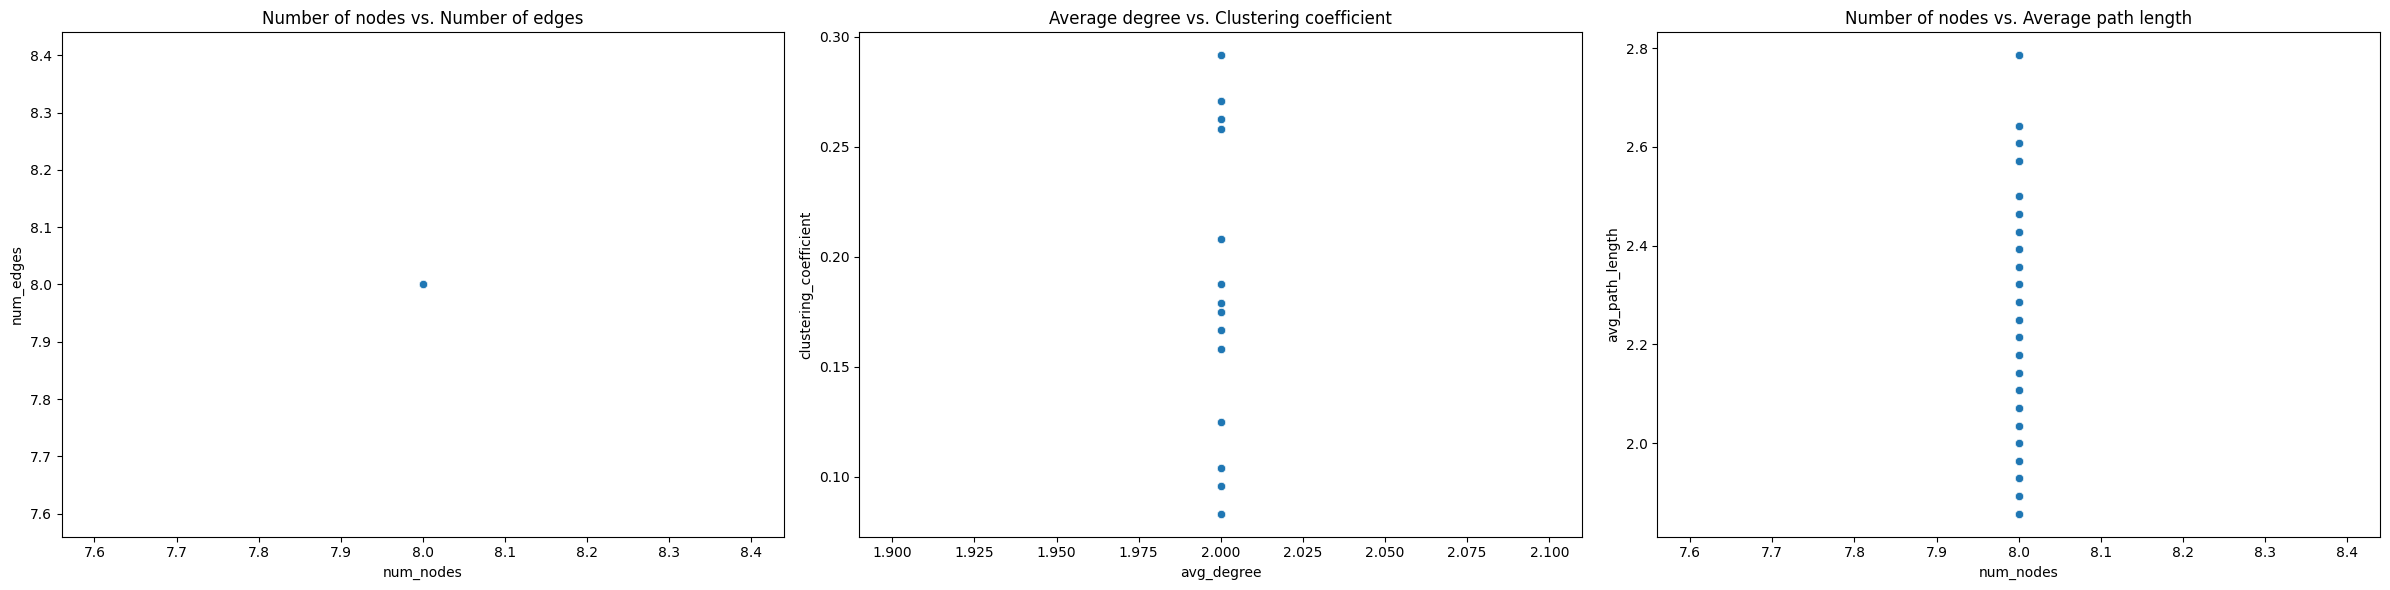

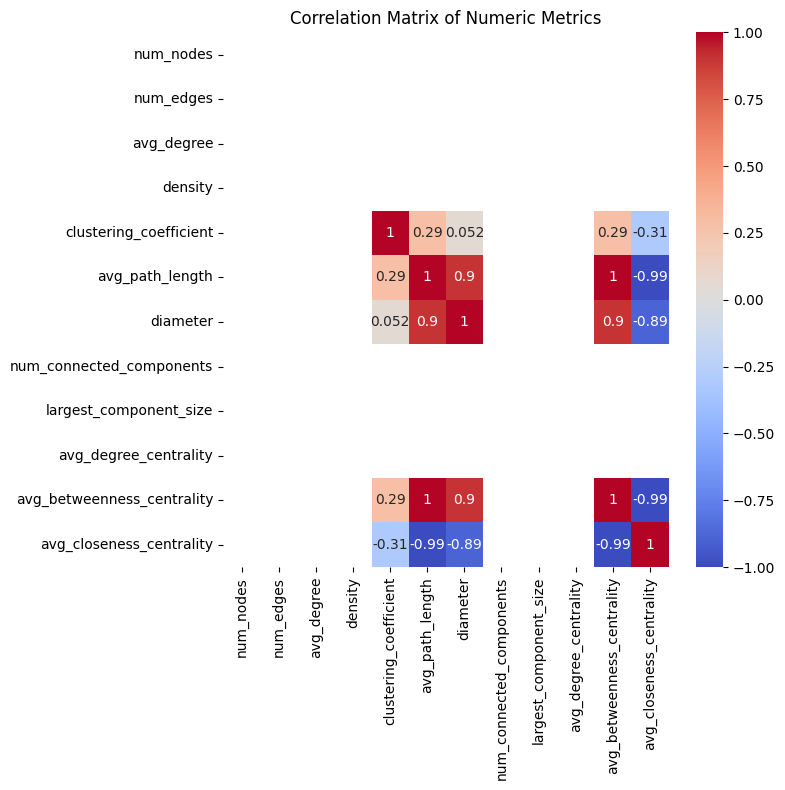

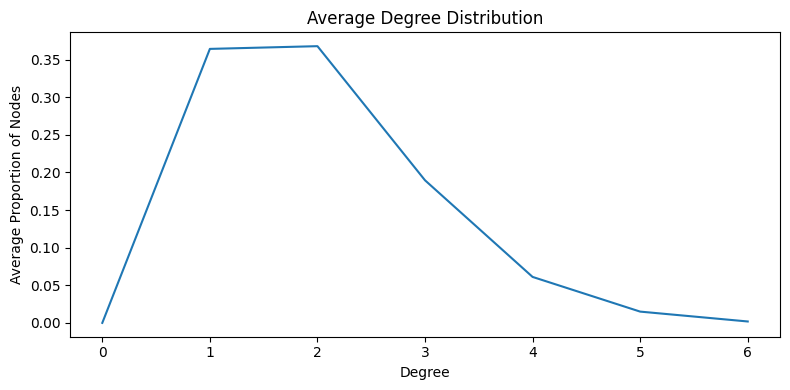

All visualizations have been displayed.


In [27]:
# Calculate metrics for each graph
individual_metrics = calculate_graph_metrics(adj_matrices_1)
# Calculate summary statistics for the dataset
dataset_summary = summarize_dataset_metrics(individual_metrics)
sns.heatmap(np.mean(adj_matrices_1, 0))
plt.title('Adjacency Matrices Edge Proportion Class=0')
# Create visualizations
create_visualizations(individual_metrics, dataset_summary)

In [6]:
class GraphDataset(Dataset):
    def __init__(self, adj_matrices, labels):
        self.adj_matrices = adj_matrices
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.adj_matrices[idx], self.labels[idx]

In [7]:
def collate_fn(batch):
    adj_matrices, labels = zip(*batch)

    # Find max number of nodes
    max_nodes = max(len(adj) for adj in adj_matrices)

    # Pad adjacency matrices
    padded_adj = []
    for adj in adj_matrices:
        pad_size = max_nodes - len(adj)
        padded = np.pad(adj, ((0, pad_size), (0, pad_size)), mode='constant')
        padded_adj.append(padded)

    # Convert to PyTorch tensors
    padded_adj = np.array(padded_adj)
    adj_tensor = torch.FloatTensor(padded_adj)

    labels_tensor = torch.FloatTensor(labels)

    return adj_tensor, labels_tensor

In [30]:
# Create dataset
dataset = GraphDataset(adj_matrices, labels)

# Create train-test split
train_size = int(0.8 * len(dataset))
print(train_size)
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

1600


### MLP

Epoch 1/50, Train Loss: 0.6944, Test Loss: 0.6938
Epoch 2/50, Train Loss: 0.6917, Test Loss: 0.6930
Epoch 3/50, Train Loss: 0.6896, Test Loss: 0.6894
Epoch 4/50, Train Loss: 0.6881, Test Loss: 0.6877
Epoch 5/50, Train Loss: 0.6864, Test Loss: 0.6885
Epoch 6/50, Train Loss: 0.6843, Test Loss: 0.6854
Epoch 7/50, Train Loss: 0.6821, Test Loss: 0.6859
Epoch 8/50, Train Loss: 0.6801, Test Loss: 0.6819
Epoch 9/50, Train Loss: 0.6775, Test Loss: 0.6789
Epoch 10/50, Train Loss: 0.6753, Test Loss: 0.6777
Epoch 11/50, Train Loss: 0.6727, Test Loss: 0.6788
Epoch 12/50, Train Loss: 0.6705, Test Loss: 0.6750
Epoch 13/50, Train Loss: 0.6677, Test Loss: 0.6788
Epoch 14/50, Train Loss: 0.6648, Test Loss: 0.6753
Epoch 15/50, Train Loss: 0.6622, Test Loss: 0.6741
Epoch 16/50, Train Loss: 0.6591, Test Loss: 0.6704
Epoch 17/50, Train Loss: 0.6561, Test Loss: 0.6706
Epoch 18/50, Train Loss: 0.6538, Test Loss: 0.6646
Epoch 19/50, Train Loss: 0.6503, Test Loss: 0.6665
Epoch 20/50, Train Loss: 0.6462, Test Lo

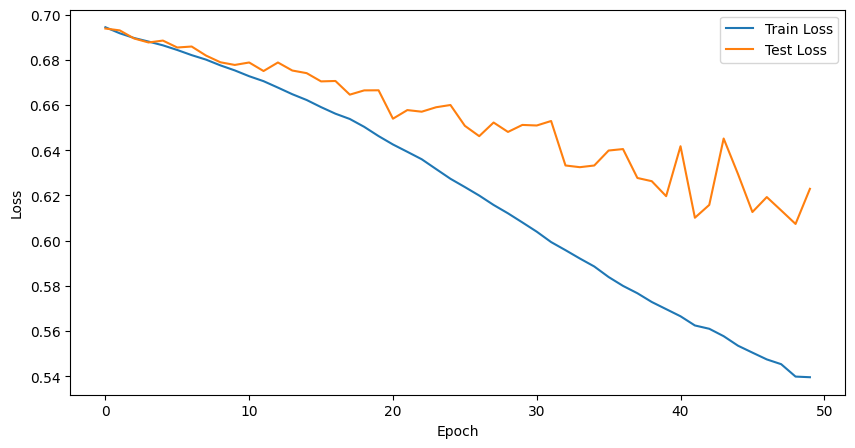

Accuracy: 0.65


In [31]:
# Generate an MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
# Initialize the model
input_size = adj_matrices.shape[1] * adj_matrices.shape[2]
hidden_size = 16
output_size = 1

model = MLP(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
train_losses = []
test_losses = []
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, labels in train_loader:
        adj = adj.view(-1, input_size)
        optimizer.zero_grad()
        outputs = model(adj)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for adj, labels in test_loader:
            adj = adj.view(-1, input_size)
            outputs = model(adj)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

    scheduler.step(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Plot the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')

plt.ylabel('Loss')
plt.legend()
plt.show()


#TODO: accuracy plots

# Show accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for adj, labels in test_loader:
        adj = adj.view(-1, input_size)
        outputs = model(adj)
        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()

print(f'Accuracy: {correct / total:.2f}')


### Transformer

In [34]:
# Create train-test split
train_size = int(0.8 * len(dataset))
print("Train Size:", train_size)
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Initialize model, loss function, and optimizer
max_nodes = 8
hidden_dim = 32
num_heads = 1
num_layers = 1
lr = 1e-3
num_epochs = 1000

# 2D positional encoding
model = GraphTransformerClassifier(max_nodes, hidden_dim, num_heads, num_layers, True)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=len(train_loader))


# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, labels in train_loader:
        adj, labels = adj.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for adj, labels in test_loader:
            adj, labels = adj.to(device), labels.to(device)
            outputs, attention_w = model(adj)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if epoch%10 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, '
            f'Val Loss: {val_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
    train_losses.append(round(train_loss/len(train_loader), 3))
    val_losses.append(round(val_loss/len(test_loader), 3))
    accuracies.append(round(100*correct/total, 3))

# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, labels in test_loader:
        adj, labels = adj.to(device), labels.to(device)
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

Train Size: 1600
Epoch 1/1000, Train Loss: 0.7362, Val Loss: 0.7079, Accuracy: 52.25%
Epoch 11/1000, Train Loss: 0.6933, Val Loss: 0.6930, Accuracy: 52.25%
Epoch 21/1000, Train Loss: 0.6931, Val Loss: 0.6935, Accuracy: 47.75%
Epoch 31/1000, Train Loss: 0.6931, Val Loss: 0.6940, Accuracy: 47.75%
Epoch 41/1000, Train Loss: 0.6931, Val Loss: 0.6936, Accuracy: 47.75%
Epoch 51/1000, Train Loss: 0.6932, Val Loss: 0.6941, Accuracy: 47.75%
Epoch 61/1000, Train Loss: 0.6932, Val Loss: 0.6944, Accuracy: 47.75%
Epoch 71/1000, Train Loss: 0.6932, Val Loss: 0.6936, Accuracy: 47.75%
Epoch 81/1000, Train Loss: 0.6934, Val Loss: 0.6930, Accuracy: 52.25%
Epoch 91/1000, Train Loss: 0.6932, Val Loss: 0.6934, Accuracy: 47.75%
Epoch 101/1000, Train Loss: 0.6932, Val Loss: 0.6939, Accuracy: 47.75%
Epoch 111/1000, Train Loss: 0.6932, Val Loss: 0.6942, Accuracy: 47.75%
Epoch 121/1000, Train Loss: 0.6933, Val Loss: 0.6937, Accuracy: 47.75%
Epoch 131/1000, Train Loss: 0.6937, Val Loss: 0.6952, Accuracy: 47.75%


In [35]:
# 1D positional encoding
model = GraphTransformerClassifier(max_nodes, hidden_dim, num_heads, num_layers, False)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=len(train_loader))


# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, labels in train_loader:
        adj, labels = adj.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for adj, labels in test_loader:
            adj, labels = adj.to(device), labels.to(device)
            outputs, attention_w = model(adj)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if epoch%10 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, '
            f'Val Loss: {val_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
    train_losses.append(round(train_loss/len(train_loader), 3))
    val_losses.append(round(val_loss/len(test_loader), 3))
    accuracies.append(round(100*correct/total, 3))

# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, labels in test_loader:
        adj, labels = adj.to(device), labels.to(device)
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

Epoch 1/1000, Train Loss: 0.6952, Val Loss: 0.6929, Accuracy: 52.25%
Epoch 11/1000, Train Loss: 0.6931, Val Loss: 0.6938, Accuracy: 47.75%
Epoch 21/1000, Train Loss: 0.6931, Val Loss: 0.6937, Accuracy: 47.75%
Epoch 31/1000, Train Loss: 0.6931, Val Loss: 0.6934, Accuracy: 47.75%
Epoch 41/1000, Train Loss: 0.6932, Val Loss: 0.6937, Accuracy: 47.75%
Epoch 51/1000, Train Loss: 0.6931, Val Loss: 0.6932, Accuracy: 47.75%
Epoch 61/1000, Train Loss: 0.6931, Val Loss: 0.6940, Accuracy: 47.75%
Epoch 71/1000, Train Loss: 0.6931, Val Loss: 0.6944, Accuracy: 47.75%
Epoch 81/1000, Train Loss: 0.6931, Val Loss: 0.6950, Accuracy: 47.75%
Epoch 91/1000, Train Loss: 0.6923, Val Loss: 0.6949, Accuracy: 49.00%
Epoch 101/1000, Train Loss: 0.6907, Val Loss: 0.6959, Accuracy: 49.75%
Epoch 111/1000, Train Loss: 0.6851, Val Loss: 0.7033, Accuracy: 47.75%
Epoch 121/1000, Train Loss: 0.6835, Val Loss: 0.6922, Accuracy: 53.50%
Epoch 131/1000, Train Loss: 0.6818, Val Loss: 0.7070, Accuracy: 50.50%
Epoch 141/1000, T

In [36]:
# Embedding Table
model = GraphTransformerClassifierET(max_nodes, hidden_dim, num_heads, num_layers)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=len(train_loader))


# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, labels in train_loader:
        adj, labels = adj.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for adj, labels in test_loader:
            adj, labels = adj.to(device), labels.to(device)
            outputs, attention_w = model(adj)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if epoch%10 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, '
            f'Val Loss: {val_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
    train_losses.append(round(train_loss/len(train_loader), 3))
    val_losses.append(round(val_loss/len(test_loader), 3))
    accuracies.append(round(100*correct/total, 3))

# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, labels in test_loader:
        adj, labels = adj.to(device), labels.to(device)
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

Epoch 1/1000, Train Loss: 0.6977, Val Loss: 0.7046, Accuracy: 47.75%
Epoch 11/1000, Train Loss: 0.6932, Val Loss: 0.6948, Accuracy: 47.75%
Epoch 21/1000, Train Loss: 0.6931, Val Loss: 0.6931, Accuracy: 47.75%
Epoch 31/1000, Train Loss: 0.6930, Val Loss: 0.6934, Accuracy: 47.75%
Epoch 41/1000, Train Loss: 0.6932, Val Loss: 0.6944, Accuracy: 47.75%
Epoch 51/1000, Train Loss: 0.6929, Val Loss: 0.6933, Accuracy: 47.75%
Epoch 61/1000, Train Loss: 0.6929, Val Loss: 0.6933, Accuracy: 48.50%
Epoch 71/1000, Train Loss: 0.6925, Val Loss: 0.6941, Accuracy: 48.50%
Epoch 81/1000, Train Loss: 0.6918, Val Loss: 0.6954, Accuracy: 50.50%
Epoch 91/1000, Train Loss: 0.6904, Val Loss: 0.6977, Accuracy: 48.75%
Epoch 101/1000, Train Loss: 0.6889, Val Loss: 0.7004, Accuracy: 51.00%
Epoch 111/1000, Train Loss: 0.6892, Val Loss: 0.6962, Accuracy: 49.25%
Epoch 121/1000, Train Loss: 0.6872, Val Loss: 0.6998, Accuracy: 48.50%
Epoch 131/1000, Train Loss: 0.6849, Val Loss: 0.7043, Accuracy: 49.25%
Epoch 141/1000, T

### Dataset 3: Only isomorphic graphs

/var/folders/z7/4w4x_vfs7k79ky63zf8xhj2w0000gn/T/ipykernel_48102/3468629238.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  print(nx.adjacency_matrix(graph).todense())


[[0 1 0 0 0 0 0 0]
 [1 0 1 1 1 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 1 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 1]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]]
[[0 1 0 0 0 0 0 0]
 [1 0 1 1 1 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 1 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 1]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]]
[[0 1 0 0 0 0 0 0]
 [1 0 1 1 1 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 1 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 1]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]]
[[0 1 0 0 0 0 0 0]
 [1 0 1 1 1 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 1 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 1]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]]
[[0 1 0 0 0 0 0 0]
 [1 0 1 1 1 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 1 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 1]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]]


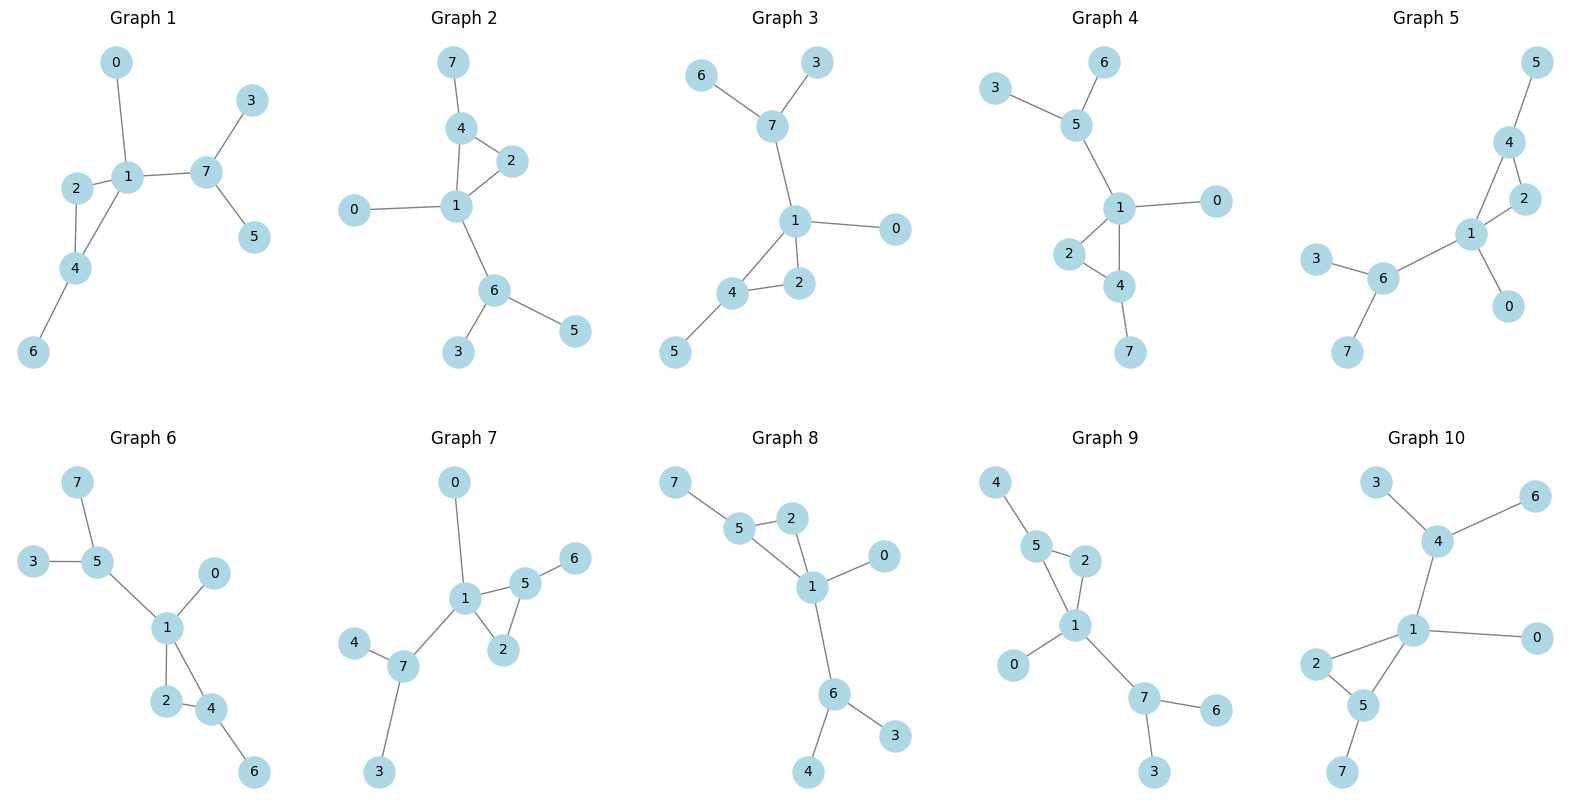

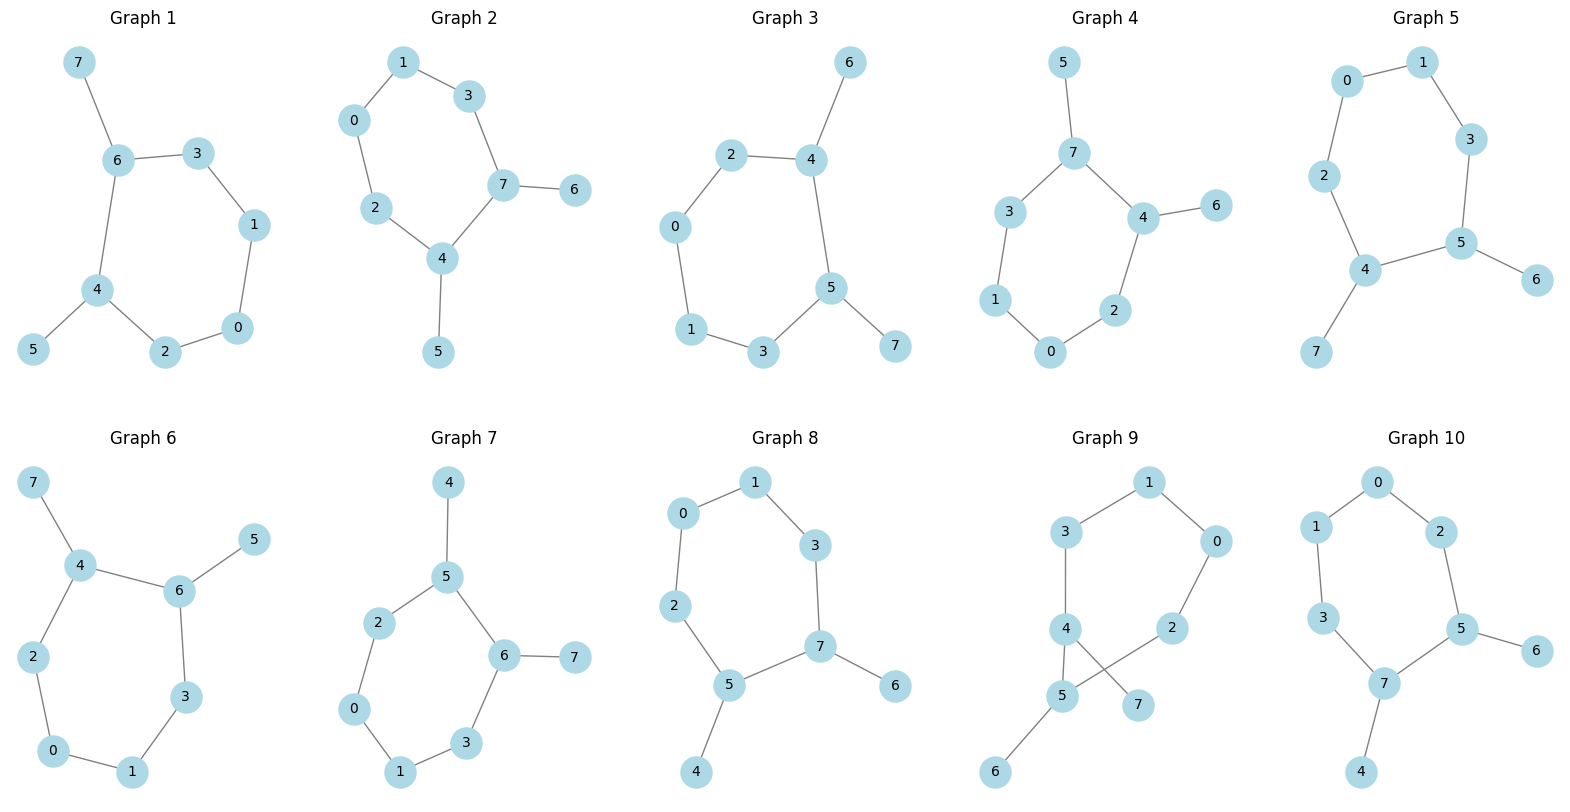

In [31]:
# Example usage
num_nodes = 8
allow_cycles = True
graphs_with_cycles, node_participation_with_cycles = generate_isomorphic_graphs(num_nodes, allow_cycles)
# Print the adjacency matrices for the first 5 graphs with cycles
for graph in graphs_with_cycles[:5]:
    print(nx.adjacency_matrix(graph).todense())
allow_cycles = False
graphs_without_cycles, node_participation_without_cycles = generate_isomorphic_graphs(num_nodes, allow_cycles)

for tree in graphs_without_cycles:
    nodes_with_degree_1 = {node: list(tree.neighbors(node)) for node in tree.nodes() if tree.degree(node) == 1}
    
    # Sort nodes with degree 1 by their neighbor's degree (or any other consistent criterion)
    sorted_degree_1_nodes = sorted(nodes_with_degree_1.items(), key=lambda x: tree.degree(x[1][0]))
    
    # pairs of nodes of degree 1 with different neighbors, maintaining order
    pairs = [(node1, node2) for i, (node1, neighbors1) in enumerate(sorted_degree_1_nodes) 
             for j, (node2, neighbors2) in enumerate(sorted_degree_1_nodes) 
             if i < j and neighbors1 != neighbors2]
    
    # Select the first pair of nodes and add that edge to the tree
    if len(pairs) > 0:
        node1, node2 = pairs[0]  # Always choose the first pair instead of a random one
        tree.add_edge(node1, node2)

plot_graphs(graphs_with_cycles[:10], node_participation_with_cycles, num_nodes, True)  # Plot the first 10 non-isomorphic graphs with cycles
plot_graphs(graphs_without_cycles[:10], node_participation_without_cycles, num_nodes, False)  # Plot the first 10 non-isomorphic graphs without cycles

In [28]:
# Make adjacency matrix from the graphs with cycles and without cycles
adj_matrices_with_cycles = [nx.adjacency_matrix(g).todense() for g in graphs_with_cycles]
adj_matrices_without_cycles = [nx.adjacency_matrix(g).todense() for g in graphs_without_cycles]

# Combine the adjacency matrices into a single dataset
adj_matrices = np.array(adj_matrices_with_cycles + adj_matrices_without_cycles)
adj_matrices.shape

# Create a list with the values of the labels
labels = [1] * len(adj_matrices_with_cycles) + [0] * len(adj_matrices_without_cycles)
labels = np.array(labels)
labels

ceros = []
unos = []
for a, l in zip(adj_matrices, labels):
  if l == 1:
    unos.append(a)
  else:
    ceros.append(a)

print("Unique Adj:", len(get_unique_adj_matrices(adj_matrices)))

print("Size per class:")
print(len(unos), len(ceros))

print("Edges per class")
print(np.mean([np.sum(c) for c in unos]), np.mean([np.sum(c) for c in ceros]))

adj_matrices_1 = adj_matrices[list(map(bool,labels)), :, :]
adj_matrices_0 = adj_matrices[list(map(lambda x: bool(0**x),labels)), :, :]

/var/folders/z7/4w4x_vfs7k79ky63zf8xhj2w0000gn/T/ipykernel_48102/1086754205.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrices_with_cycles = [nx.adjacency_matrix(g).todense() for g in graphs_with_cycles]
/var/folders/z7/4w4x_vfs7k79ky63zf8xhj2w0000gn/T/ipykernel_48102/1086754205.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrices_without_cycles = [nx.adjacency_matrix(g).todense() for g in graphs_without_cycles]


Unique Adj: 2
Size per class:
40320 40320
Edges per class
16.0 16.0


In [8]:
# Create dataset
dataset = GraphDataset(adj_matrices, labels)

# Create train-test split
train_size = int(0.8 * len(dataset))
print(train_size)
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

64512


Epoch 1/50, Train Loss: 0.0504, Test Loss: 0.0011
Epoch 2/50, Train Loss: 0.0005, Test Loss: 0.0003
Epoch 3/50, Train Loss: 0.0002, Test Loss: 0.0001
Epoch 4/50, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 5/50, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 6/50, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 7/50, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 8/50, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 9/50, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 10/50, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 11/50, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 12/50, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 13/50, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 14/50, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 15/50, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 16/50, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 17/50, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 18/50, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 19/50, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 20/50, Train Loss: 0.0000, Test Lo

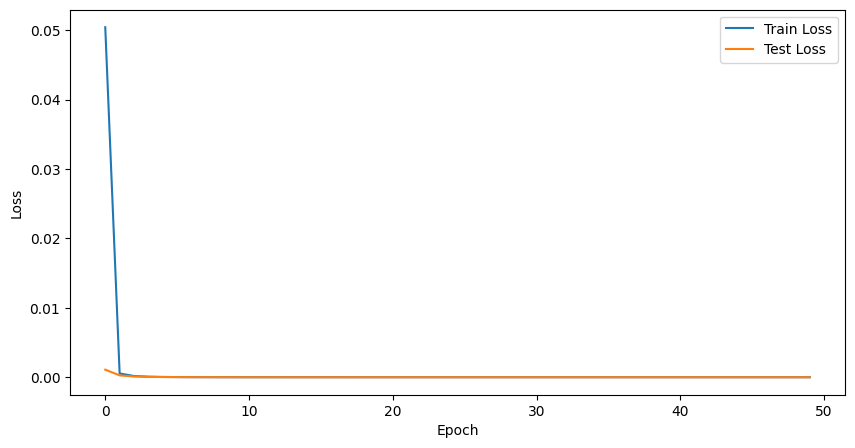

Accuracy: 1.00


In [9]:
# Generate an MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
# Initialize the model
input_size = adj_matrices.shape[1] * adj_matrices.shape[2]
hidden_size = 16
output_size = 1

model = MLP(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
train_losses = []
test_losses = []
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, labels in train_loader:
        adj = adj.view(-1, input_size)
        optimizer.zero_grad()
        outputs = model(adj)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for adj, labels in test_loader:
            adj = adj.view(-1, input_size)
            outputs = model(adj)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

    scheduler.step(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Plot the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')

plt.ylabel('Loss')
plt.legend()
plt.show()


#TODO: accuracy plots

# Show accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for adj, labels in test_loader:
        adj = adj.view(-1, input_size)
        outputs = model(adj)
        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()

print(f'Accuracy: {correct / total:.2f}')


In [13]:
# Create train-test split
train_size = int(0.8 * len(dataset))
print("Train Size:", train_size)
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Initialize model, loss function, and optimizer
max_nodes = 8
hidden_dim = 32
num_heads = 1
num_layers = 1
lr = 1e-3
num_epochs = 1000

# 2D positional encoding
model = GraphTransformerClassifier(max_nodes, hidden_dim, num_heads, num_layers, True)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=len(train_loader))


# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, labels in train_loader:
        adj, labels = adj.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for adj, labels in test_loader:
            adj, labels = adj.to(device), labels.to(device)
            outputs, attention_w = model(adj)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if epoch%10 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, '
            f'Val Loss: {val_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
    train_losses.append(round(train_loss/len(train_loader), 3))
    val_losses.append(round(val_loss/len(test_loader), 3))
    accuracies.append(round(100*correct/total, 3))

# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, labels in test_loader:
        adj, labels = adj.to(device), labels.to(device)
        outputs, attention_w = model(adj)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

Train Size: 64512
Epoch 1/1000, Train Loss: 0.6888, Val Loss: 0.6729, Accuracy: 100.00%


KeyboardInterrupt: 

### Triangle Edge Detection

In [ ]:
class GraphTransformerTriangleEdgeDetector(nn.Module):
    def __init__(self, max_nodes, hidden_dim, num_heads, num_layers):
        super(GraphTransformerTriangleEdgeDetector, self).__init__()
        self.max_nodes = max_nodes
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.num_layers = num_layers

        # 2D positional encoding
        self.pos_encoding = Summer(PositionalEncoding2D(hidden_dim))

        # Initial transformation of adjacency matrix
        self.input_proj = nn.Linear(1, hidden_dim)

        # Graph Transformer layers
        self.layers = nn.ModuleList([
            GraphTransformerLayer(hidden_dim, num_heads)
            for _ in range(num_layers)
        ])

        # Edge classifier
        self.edge_classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, adj_matrix):
        # adj_matrix: [batch_size, num_nodes, num_nodes]
        batch_size, num_nodes, _ = adj_matrix.size()

        # Pad adjacency matrix if necessary
        if num_nodes < self.max_nodes:
            padding = torch.zeros(batch_size, self.max_nodes - num_nodes, num_nodes, device=adj_matrix.device)
            adj_matrix = torch.cat([adj_matrix, padding], dim=1)
            padding = torch.zeros(batch_size, self.max_nodes, self.max_nodes - num_nodes, device=adj_matrix.device)
            adj_matrix = torch.cat([adj_matrix, padding], dim=2)

        # Initial projection of adjacency matrix
        x = self.input_proj(adj_matrix.unsqueeze(-1))  # [batch_size, max_nodes, max_nodes, hidden_dim]

        # Add positional encoding
        x = self.pos_encoding(x)

        # Reshape for transformer layers
        x = x.view(batch_size, self.max_nodes * self.max_nodes, self.hidden_dim)

        # Create attention mask
        attention_mask = adj_matrix.view(batch_size, self.max_nodes * self.max_nodes)
        attention_mask = attention_mask.unsqueeze(1).repeat(1, self.max_nodes * self.max_nodes, 1)
        attention_mask = (attention_mask == 0).float()
        attention_mask = attention_mask.repeat(self.num_heads, 1, 1)

        # Apply Graph Transformer layers
        for layer in self.layers:
            x, attn_weights = layer(x, attention_mask)
            attention_weights.append(attn_weights)

        # Reshape back to [batch_size, max_nodes, max_nodes, hidden_dim]
        x = x.view(batch_size, self.max_nodes, self.max_nodes, self.hidden_dim)

        # Apply edge classifier
        edge_probs = self.edge_classifier(x).squeeze(-1)

        # Make the output symmetric and zero out the diagonal
        edge_probs = (edge_probs + edge_probs.transpose(1, 2)) / 2
        edge_probs = edge_probs * (1 - torch.eye(self.max_nodes, device=edge_probs.device))

        return edge_probs

# The GraphTransformerLayer remains the same as in the original code

# Example usage
max_nodes = 5
hidden_dim = 32  # Increased for better representation
num_heads = 4
num_layers = 3
model = GraphTransformerTriangleEdgeDetector(max_nodes, hidden_dim, num_heads, num_layers)

# Create a sample adjacency matrix (batch_size=1, num_nodes=5)
adj_matrix = torch.tensor([[[0, 1, 1, 0, 0],
                            [1, 0, 1, 0, 0],
                            [1, 1, 0, 0, 0],
                            [0, 0, 0, 0, 1],
                            [0, 0, 0, 1, 0]]], dtype=torch.float32)

output = model(adj_matrix)
print(f"Output shape: {output.shape}")
print(f"Output probabilities:\n{output[0]}")

In [ ]:
# Example usage:
num_nodes = 10
edge_probability = 0.3
num_graphs = 10000

adj_matrices, edge_labels = generate_unique_random_graphs_with_triangles(num_nodes, edge_probability, num_graphs)

print(f"Number of unique graphs generated: {len(adj_matrices)}")
print(f"Shape of each adjacency matrix: {adj_matrices[0].shape}")
print(f"Shape of each edge label matrix: {edge_labels[0].shape}")

# Example of one graph
print("\nExample Graph:")
print("Adjacency Matrix:")
print(adj_matrices[0])
print("\nEdge Labels (1 indicates edge is part of a triangle):")
print(edge_labels[0])

# Count triangles in the example graph
num_triangles = edge_labels[0].sum().item() // 3  # Divide by 3 as each triangle is counted 3 times
print(f"\nNumber of triangles in the example graph: {num_triangles}")

# Verify uniqueness
unique_hashes = set(hashlib.md5(adj.numpy().tobytes()).hexdigest() for adj in adj_matrices)
print(f"\nNumber of unique hashes: {len(unique_hashes)}")
print(f"All graphs are unique: {len(unique_hashes) == len(adj_matrices)}")

In [ ]:
show_interactive_graph_with_labels(adj_matrices[0].numpy())

In [ ]:
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, adj_matrices, edge_labels):
        self.adj_matrices = adj_matrices
        self.edge_labels = edge_labels

    def __len__(self):
        return len(self.adj_matrices)

    def __getitem__(self, idx):
        return self.adj_matrices[idx], self.edge_labels[idx]

def collate_fn(batch):
    adj_matrices, edge_labels = zip(*batch)
    adj_matrices = pad_sequence([adj.view(-1) for adj in adj_matrices], batch_first=True)
    edge_labels = pad_sequence([label.view(-1) for label in edge_labels], batch_first=True)
    max_nodes = int(adj_matrices.size(1)**0.5)
    return adj_matrices.view(-1, max_nodes, max_nodes), edge_labels.view(-1, max_nodes, max_nodes)

dataset = GraphDataset(adj_matrices, edge_labels)

# Create train-test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Initialize model, loss function, and optimizer
max_nodes = adj_matrices[0].shape[0]  # Assuming all matrices have the same size
hidden_dim = 32
num_heads = 8
num_layers = 1
lr = 1e-3
num_epochs = 8000

model = GraphTransformerTriangleEdgeDetector(max_nodes, hidden_dim, num_heads, num_layers)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=len(train_loader))

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for adj, edge_labels in train_loader:
        adj, edge_labels = adj.to(device), edge_labels.to(device)

        optimizer.zero_grad()
        outputs = model(adj)

        # Apply mask to only consider existing edges
        mask = adj != 0
        loss = criterion(outputs[mask], edge_labels[mask])

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for adj, edge_labels in test_loader:
            adj, edge_labels = adj.to(device), edge_labels.to(device)
            outputs = model(adj)

            # Apply mask to only consider existing edges
            mask = adj != 0
            loss = criterion(outputs[mask], edge_labels[mask])
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += mask.sum().item()
            correct += ((predicted == edge_labels) & mask).sum().item()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, '
          f'Val Loss: {val_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')
    train_losses.append(round(train_loss/len(train_loader), 3))
    val_losses.append(round(val_loss/len(test_loader), 3))
    accuracies.append(round(100*correct/total, 3))

# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, edge_labels in test_loader:
        adj, edge_labels = adj.to(device), edge_labels.to(device)
        outputs = model(adj)

        # Apply mask to only consider existing edges
        mask = adj != 0
        loss = criterion(outputs[mask], edge_labels[mask])
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += mask.sum().item()
        correct += ((predicted == edge_labels) & mask).sum().item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

In [ ]:
# Final test
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for adj, edge_labels in test_loader:
        adj, edge_labels = adj.to(device), edge_labels.to(device)
        outputs = model(adj)

        # Apply mask to only consider existing edges
        mask = adj != 0
        loss = criterion(outputs[mask], edge_labels[mask])
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total += mask.sum().item()
        correct += ((predicted == edge_labels) & mask).sum().item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100*correct/total:.2f}%')